In [1]:
import os

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# 解壓縮資料

In [2]:
def unzip_data(path):
    for folder, _, files in os.walk(path):
        for file in files:
            if file.endswith('zip'):
                file_path = os.path.join(folder, file)
                print(file_path)

                sotre_path = os.path.join(folder, file.rsplit('.')[0])
                # 開啟 ZIP 壓縮檔 
                with zipfile.ZipFile(file_path, 'r') as zf:
                    # 解壓縮所有檔案至 /my/folder 目錄
                    zf.extractall(path=sotre_path)

In [3]:
# unzip_data('./swing')

In [4]:
def convert_csv(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=',')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=',')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=',')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=',')
    device_df = pd.read_csv(os.path.join(path, 'meta', 'device.csv'), delimiter=',')
    time_df = pd.read_csv(os.path.join(path, 'meta', 'time.csv'), delimiter=',')
    
    acc_df.to_csv(os.path.join(path, 'Accelerometer.csv'), index=False, sep=';')
    gyo_df.to_csv(os.path.join(path, 'Gyroscope.csv'), index=False, sep=';')
    linacc_df.to_csv(os.path.join(path, 'Linear Accelerometer.csv'), index=False, sep=';')
    mag_df.to_csv(os.path.join(path, 'Magnetometer.csv'), index=False, sep=';')
    device_df.to_csv(os.path.join(path, 'meta', 'device.csv'), index=False, sep=';')
    time_df.to_csv(os.path.join(path, 'meta', 'time.csv'), index=False, sep=';')

In [5]:
# convert_csv('./pocket/202301101952/target')
# convert_csv('./pocket/202301101952/source')

# 讀檔

In [6]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path):
    time_df = pd.read_csv(path, delimiter=';', index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def load_original_data(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=';')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=';')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'))
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, gyo_df, linacc_df, mag_df], axis=1)
    total_df = rename_data(total_df)
    
    return total_df

In [7]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, chunk_size=5, seq_len=25):
#     length = datapoint_per_second * duration
    length = chunk_size * seq_len
    num_of_segs = int(np.floor(len(df) / length))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * length):int((i + 1) * length)].to_numpy()
        segments.append(np.array(np.split(seg, chunk_size)))
        
    return segments


def select_data(df):
    return df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'system_time']]


def preprocess_data(df, chunk_size=5, seq_len=25):
    pre_df = select_data(df)
    segs = split_segments(pre_df, chunk_size, seq_len)
    
    return segs

In [8]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

        print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num):
    pair_data = []

    for folder in os.listdir(root_folder):
        if folder.startswith('.'):
            continue

        folder_path = os.path.join(root_folder, folder)
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(folder_path)
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path)
        target_df = load_original_data(target_path)
        
#         print(source_df.system_time[0], target_df.system_time[0])
        
        source_df, target_df = align_data(source_df, target_df)
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        
#         print(source_df.system_time[0], target_df.system_time[0])
#         print(source_df.system_time[len(source_df) - 1], target_df.system_time[len(target_df) - 1])
#         print(len(source_df), len(target_df))
        
#         plt.figure(figsize=(30, 5))
#         plt.plot(np.arange(len(source_df)), source_df.acc_x)
#         plt.plot(np.arange(len(target_df)), target_df.acc_y)
#         plt.show()
        
        source_segs = preprocess_data(source_df, chunk_size, seq_len)
        target_segs = preprocess_data(target_df, chunk_size, seq_len)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
        
    return pair_data

In [9]:
datapoint_per_second = 20
duration = 2
chunk_size = 7
seq_len = 21
classes = {'target': 0, 'front_pocket': 1, 'pocket': 2, 'swing': 3}

In [10]:
source_device_version = device_version('./front_pocket/202302071523/source/meta/device.csv')
target_device_version = device_version('./front_pocket/202302071523/target/meta/device.csv')
print(f"source device version: {source_device_version}")  # source version: 15.4
print(f"target device version: {target_device_version}")  # target version: 16.3

source device version: 15.4
target device version: 16.3


In [11]:
front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1)
pocket_pair_data = load_pair_data('./pocket', class_num=2)
swing_pair_data = load_pair_data('./swing', class_num=3)

./front_pocket/202302071628
./front_pocket/202302071628/source ./front_pocket/202302071628/target
./front_pocket/202302071652
./front_pocket/202302071652/source ./front_pocket/202302071652/target
./front_pocket/202302071523
./front_pocket/202302071523/source ./front_pocket/202302071523/target
./front_pocket/202302071531
./front_pocket/202302071531/source ./front_pocket/202302071531/target
./front_pocket/202302071715
./front_pocket/202302071715/source ./front_pocket/202302071715/target
./front_pocket/202302071641
./front_pocket/202302071641/source ./front_pocket/202302071641/target
./front_pocket/202302071541
./front_pocket/202302071541/source ./front_pocket/202302071541/target
./front_pocket/202302071619
./front_pocket/202302071619/source ./front_pocket/202302071619/target
./front_pocket/202302071704
./front_pocket/202302071704/source ./front_pocket/202302071704/target
./front_pocket/202302071724
./front_pocket/202302071724/source ./front_pocket/202302071724/target
./pocket/20230213210

In [12]:
print(len(front_pocket_pair_data), len(pocket_pair_data), len(swing_pair_data))

388 370 364


In [13]:
front_pocket_pair_data[0][0][0, -1], front_pocket_pair_data[0][2][0, -1]

(array([-1.46666997e+00,  3.02090550e-02,  1.02965024e+00, -4.78252917e-01,
        -3.82730037e-01,  1.22318631e-02,  8.28334045e+00, -1.33542404e+01,
         4.17045288e+01,  1.67575811e+09]),
 array([ 1.25826234e-01, -1.58992693e+00, -1.53935553e+00, -6.28472567e-02,
         3.16822752e-02,  2.58390278e-01, -3.71943283e+01,  1.32483292e+00,
        -2.49790649e+01,  1.67575811e+09]))

# 建立dataloader

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [15]:
# class ClassDataset(Dataset):
#     def __init__(self, data, label):
#         self.data = data
#         self.label = label

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx], self.label[idx]

In [16]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [17]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]

    return mask

In [18]:
class Classifier(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(Classifier, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.cnn = nn.Sequential(
            nn.Conv1d(6, 16, kernel_size=5),
            nn.LeakyReLU(),
            nn.Conv1d(16, 16, kernel_size=5),
            nn.LeakyReLU(),
        )
        
        # 16 * (seq_len-8)
        self.rnn = nn.RNN(input_size=16 * (seq_len - 8), hidden_size=64, num_layers=2, batch_first=True)
        
        self.last = nn.Sequential(
            nn.Linear(64, 16),
            nn.Tanh(),
            nn.Linear(16, num_of_classes),
            nn.Softmax(dim=2),
        )
        
    def forward(self, x):  # input: (bs, chunk_size, seq_len, 9)
        h = torch.reshape(x, (len(x) * self.chunk_size, self.seq_len, -1))  # (bs, chunk_size, seq_len, 9) -> (bs * chunk_size, seq_len, 9)
        h = torch.permute(h, (0, 2, 1))  # (bs * chunk_size, seq_len, 9) -> (bs * chunk_size, 9, seq_len) [CNN要對最後一個維度做卷積]
        
        h = self.cnn(h)

        h = torch.permute(h, (0, 2, 1))
        h = torch.reshape(h, (len(x), self.chunk_size, -1))
        
        hz, _ = self.rnn(h)
        out = self.last(hz)

        out = torch.reshape(out, (len(x), self.chunk_size, self.num_of_classes))
        
        return out, hz
    

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.imu_layer = nn.Sequential(
            nn.Linear(6, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 32),
            nn.LeakyReLU(),
        )
        self.mag_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 32),
            nn.LeakyReLU(),
        )
        self.pos_encoder = PositionalEncoding(32 * self.seq_len, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=32 * self.seq_len, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
        self.nn = nn.Sequential(
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 6),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=32 * self.seq_len, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
        
        self.mag_last = nn.Sequential(
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 3),
        )
        
    def forward(self, source_imu, source_mag):
        
        ### step 1
        h_imu = self.imu_layer(source_imu)
        h_imu = h_imu.reshape((len(source_imu), self.chunk_size, -1))
        h_imu = self.pos_encoder(h_imu)
        
        h_mag = self.mag_layer(source_mag)
        h_mag = h_mag.reshape((len(source_mag), self.chunk_size, -1))
        h_mag = self.pos_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = z.reshape((len(source_imu), self.chunk_size, self.seq_len, -1))
        z_imu = self.nn(z_imu)
        
        ### step 3
        pred_latent = self.decoder(h_mag, z)
        pred_mag = pred_latent.reshape((len(source_mag), self.chunk_size, self.seq_len, -1))
        pred_mag = self.mag_last(pred_mag)
        
        
        return z_imu, pred_mag
        

In [19]:
# class Discriminator(nn.Module):
#     def __init__(self, chunk_size=5, seq_len=21):
#         super(Discriminator, self).__init__()
        
#         self.chunk_size = chunk_size
#         self.seq_len = seq_len
        
#         self.feature_extractor = nn.Sequential(
#             nn.Linear(3, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 32),
#             nn.LeakyReLU(),
#         )
        
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
        
#         self.discriminant_layer = nn.Sequential(
#             nn.Linear(64 * self.seq_len, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 1),
#             nn.Sigmoid(),
#         )
        
#     def forward(self, x):
#         h = self.feature_extractor(x)  # (bs, chunk_size, seq_len, 3) -> (bs, chunk_size, seq_len, 16)
        
#         h = h.reshape((len(x), self.chunk_size, -1))  # (bs, chunk_size, seq_len, 16) -> (bs, chunk_size, seq_len * 16)
#         hz, _ = self.lstm(h)  # (bs, chunk_size, seq_len * 16) -> (bs, chunk_size, seq_len * 16 * 2)
        
#         out = self.discriminant_layer(hz)
        
#         return out

In [20]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag):
    imu_loss = mse_loss(z_imu, target_imu)
    mag_loss = mse_loss(predict_mag, target_mag)

    total_loss = imu_loss + mag_loss
    return total_loss, imu_loss, mag_loss

# def discriminator_loss(d_real, d_fake):
#     real_loss = bce_loss(d_real, torch.ones_like(d_real))
#     fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

#     return real_loss + fake_loss

In [21]:
front_pocket_half = int(len(front_pocket_pair_data) * 0.8)
pocket_half = int(len(pocket_pair_data) * 0.8)
swing_half = int(len(swing_pair_data) * 0.8)

train_data = front_pocket_pair_data[:front_pocket_half] + pocket_pair_data[:pocket_half] + swing_pair_data[:swing_half]
valid_data = front_pocket_pair_data[front_pocket_half:] + pocket_pair_data[pocket_half:] + swing_pair_data[swing_half:]

# train
train_source_data = np.array([d[0] for d in train_data])
train_source_label = np.array([d[1] for d in train_data])
train_target_data = np.array([d[2] for d in train_data])
train_target_label = np.array([d[3] for d in train_data])
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                )
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# valid
valid_source_data = np.array([d[0] for d in valid_data])
valid_source_label = np.array([d[1] for d in valid_data])
valid_target_data = np.array([d[2] for d in valid_data])
valid_target_label = np.array([d[3] for d in valid_data])
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                )
valid_loader = DataLoader(valid_dataset, batch_size=256)

In [22]:
batch = next(iter(train_loader))

In [23]:
# batch

In [24]:
EPOCH = 6000
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()

In [25]:
model = NotSimpleTransformer(chunk_size=chunk_size, seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# discriminator = Discriminator(chunk_size=chunk_size, seq_len=seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.000025)

In [26]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [27]:
def train(dataloader, draw=False):
    model.train()

    g_losses = []
    imu_losses = []
    mag_losses = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, :, :6]
        source_mag = source_data[:, :, :, 6:9]
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, :, :6]
        target_mag = target_data[:, :, :, 6:9]

        # generate mag
        z_imu, predict_mag = model(source_imu, source_mag)
        
        # generator loss
        gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses)

In [28]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :, :6]
            source_mag = source_data[:, :, :, 6:9]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :, :6]
            target_mag = target_data[:, :, :, 6:9]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
            gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses)

00019: train loss:  633.901, imu loss:  0.685, mag loss:  633.217
       valid loss:  629.346, imu loss:  0.515, mag loss:  628.831
00039: train loss:  630.778, imu loss:  0.689, mag loss:  630.090
       valid loss:  622.789, imu loss:  0.511, mag loss:  622.278
00059: train loss:  615.866, imu loss:  0.686, mag loss:  615.181
       valid loss:  614.800, imu loss:  0.510, mag loss:  614.289
00079: train loss:  611.770, imu loss:  0.680, mag loss:  611.090
       valid loss:  607.283, imu loss:  0.510, mag loss:  606.773
00099: train loss:  599.225, imu loss:  0.681, mag loss:  598.544
       valid loss:  599.637, imu loss:  0.510, mag loss:  599.128
00119: train loss:  591.579, imu loss:  0.671, mag loss:  590.908
       valid loss:  592.396, imu loss:  0.510, mag loss:  591.886
00139: train loss:  581.883, imu loss:  0.678, mag loss:  581.205
       valid loss:  583.977, imu loss:  0.510, mag loss:  583.467
00159: train loss:  577.952, imu loss:  0.679, mag loss:  577.273
       val

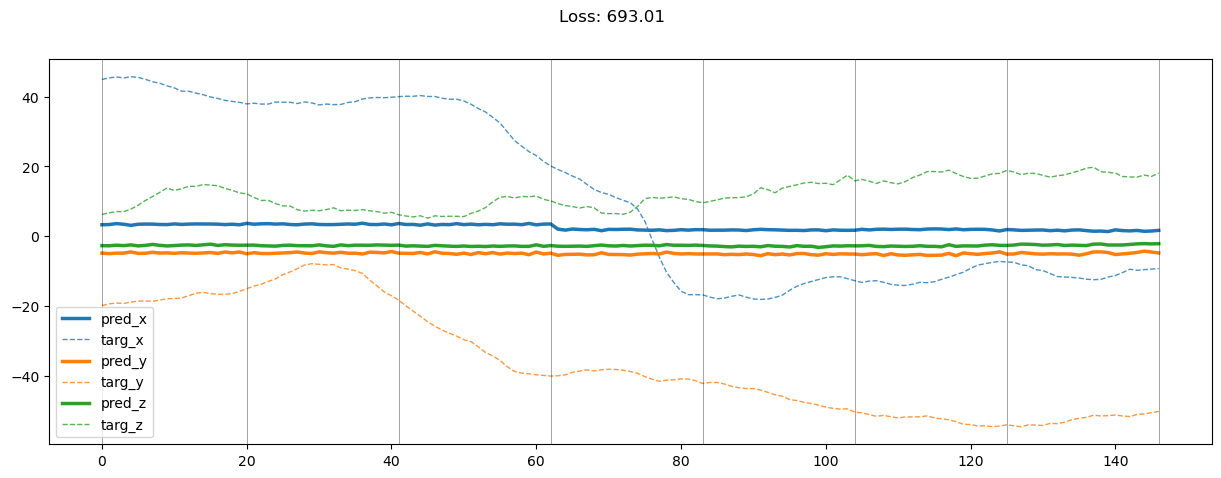

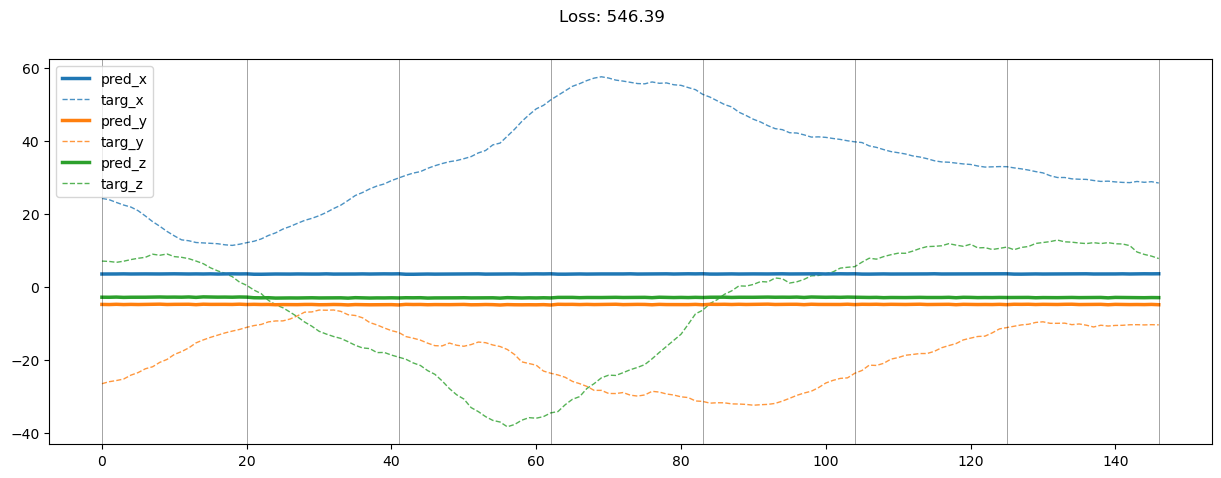

00199: train loss:  557.680, imu loss:  0.674, mag loss:  557.006
       valid loss:  553.959, imu loss:  0.511, mag loss:  553.448
00219: train loss:  545.107, imu loss:  0.682, mag loss:  544.424
       valid loss:  544.110, imu loss:  0.510, mag loss:  543.600
00239: train loss:  537.408, imu loss:  0.690, mag loss:  536.718
       valid loss:  533.820, imu loss:  0.510, mag loss:  533.310
00259: train loss:  522.662, imu loss:  0.684, mag loss:  521.978
       valid loss:  523.478, imu loss:  0.510, mag loss:  522.968
00279: train loss:  510.700, imu loss:  0.672, mag loss:  510.027
       valid loss:  513.413, imu loss:  0.510, mag loss:  512.903
00299: train loss:  501.014, imu loss:  0.686, mag loss:  500.329
       valid loss:  502.728, imu loss:  0.510, mag loss:  502.218
00319: train loss:  491.422, imu loss:  0.684, mag loss:  490.738
       valid loss:  492.337, imu loss:  0.510, mag loss:  491.827
00339: train loss:  479.154, imu loss:  0.681, mag loss:  478.473
       val

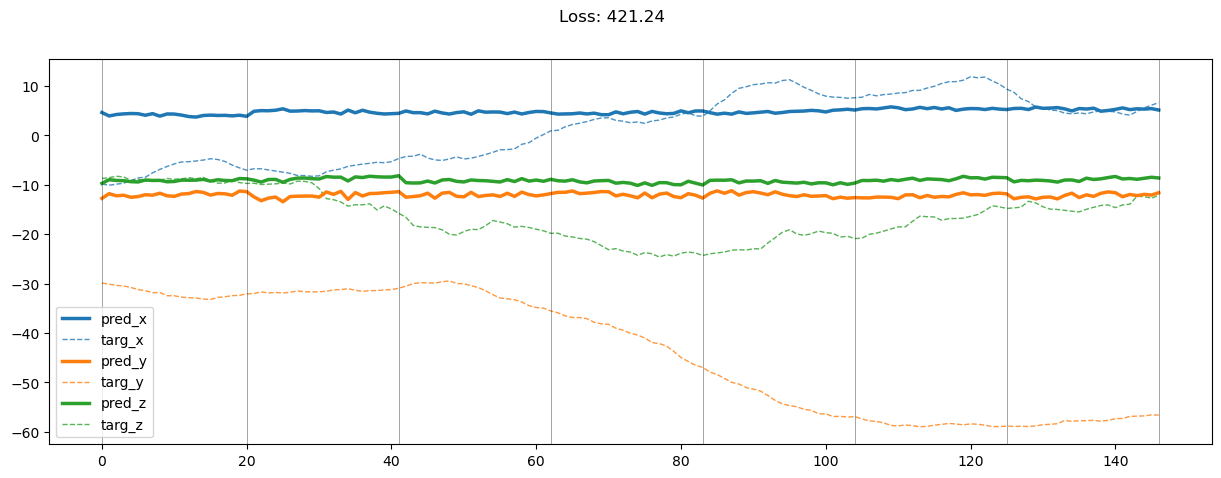

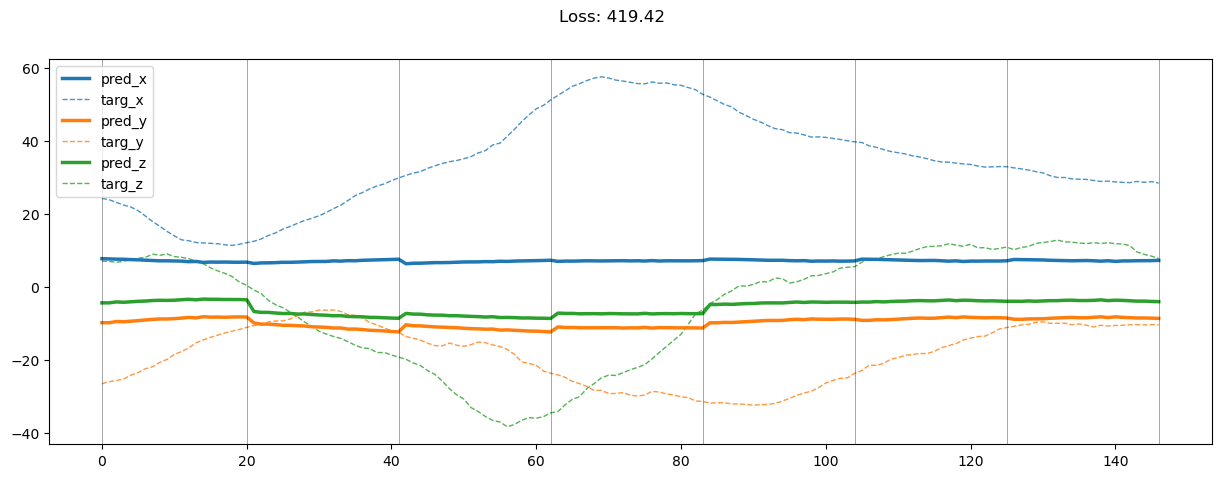

00399: train loss:  448.513, imu loss:  0.676, mag loss:  447.837
       valid loss:  451.588, imu loss:  0.510, mag loss:  451.078
00419: train loss:  439.252, imu loss:  0.681, mag loss:  438.571
       valid loss:  440.554, imu loss:  0.510, mag loss:  440.044
00439: train loss:  427.482, imu loss:  0.675, mag loss:  426.808
       valid loss:  430.658, imu loss:  0.510, mag loss:  430.148
00459: train loss:  417.261, imu loss:  0.672, mag loss:  416.589
       valid loss:  421.605, imu loss:  0.510, mag loss:  421.095
00479: train loss:  408.718, imu loss:  0.680, mag loss:  408.038
       valid loss:  411.596, imu loss:  0.510, mag loss:  411.086
00499: train loss:  401.001, imu loss:  0.681, mag loss:  400.320
       valid loss:  403.018, imu loss:  0.510, mag loss:  402.508
00519: train loss:  387.589, imu loss:  0.671, mag loss:  386.918
       valid loss:  393.511, imu loss:  0.510, mag loss:  393.001
00539: train loss:  377.922, imu loss:  0.680, mag loss:  377.242
       val

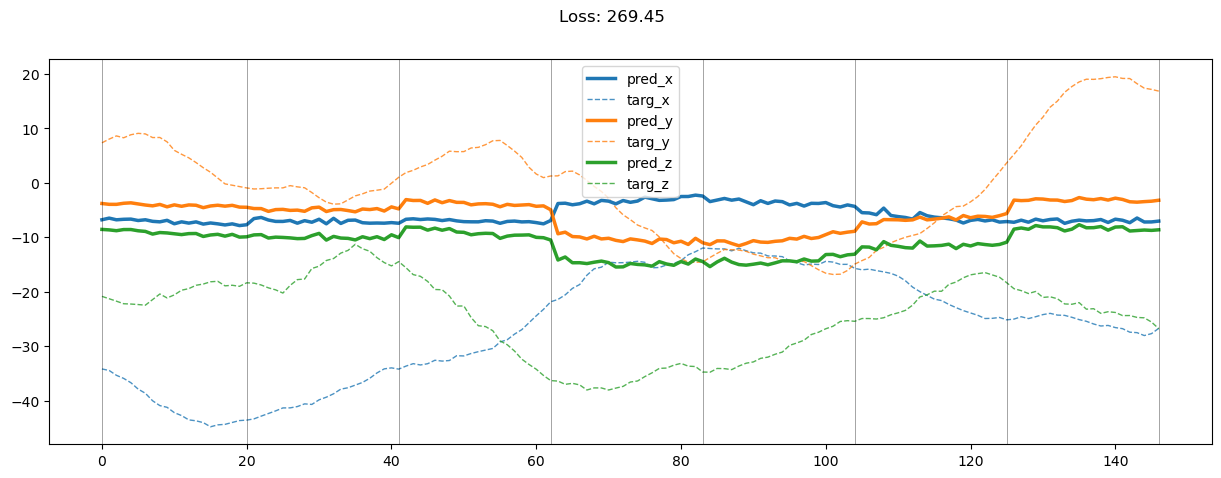

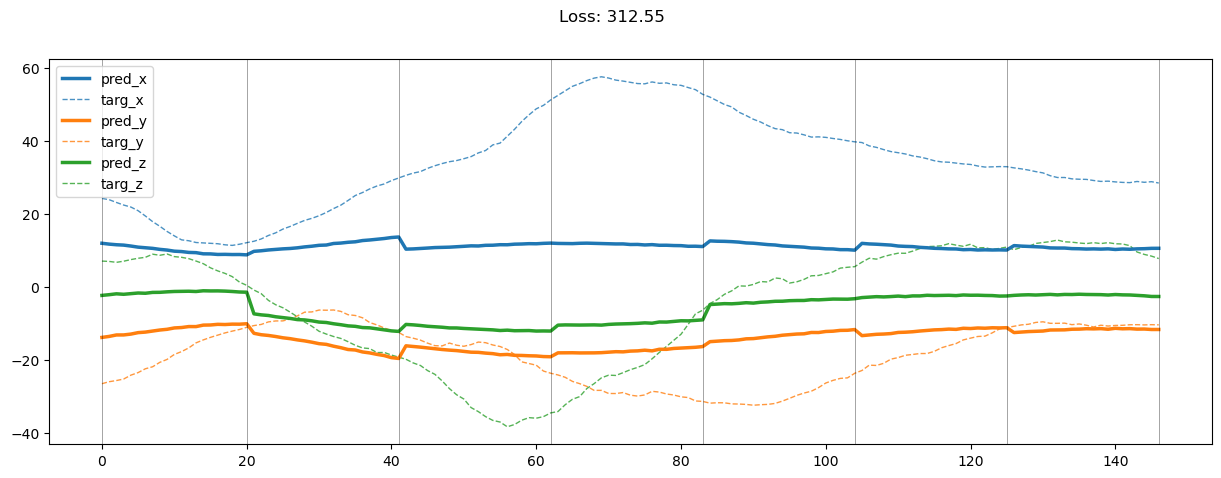

00599: train loss:  352.706, imu loss:  0.677, mag loss:  352.029
       valid loss:  358.674, imu loss:  0.510, mag loss:  358.164
00619: train loss:  341.279, imu loss:  0.685, mag loss:  340.594
       valid loss:  349.650, imu loss:  0.510, mag loss:  349.140
00639: train loss:  332.257, imu loss:  0.689, mag loss:  331.569
       valid loss:  341.725, imu loss:  0.510, mag loss:  341.215
00659: train loss:  326.063, imu loss:  0.680, mag loss:  325.383
       valid loss:  332.796, imu loss:  0.510, mag loss:  332.287
00679: train loss:  318.192, imu loss:  0.678, mag loss:  317.514
       valid loss:  326.005, imu loss:  0.510, mag loss:  325.495
00699: train loss:  309.082, imu loss:  0.679, mag loss:  308.403
       valid loss:  316.342, imu loss:  0.510, mag loss:  315.832
00719: train loss:  300.641, imu loss:  0.673, mag loss:  299.969
       valid loss:  309.041, imu loss:  0.510, mag loss:  308.531
00739: train loss:  293.864, imu loss:  0.674, mag loss:  293.190
       val

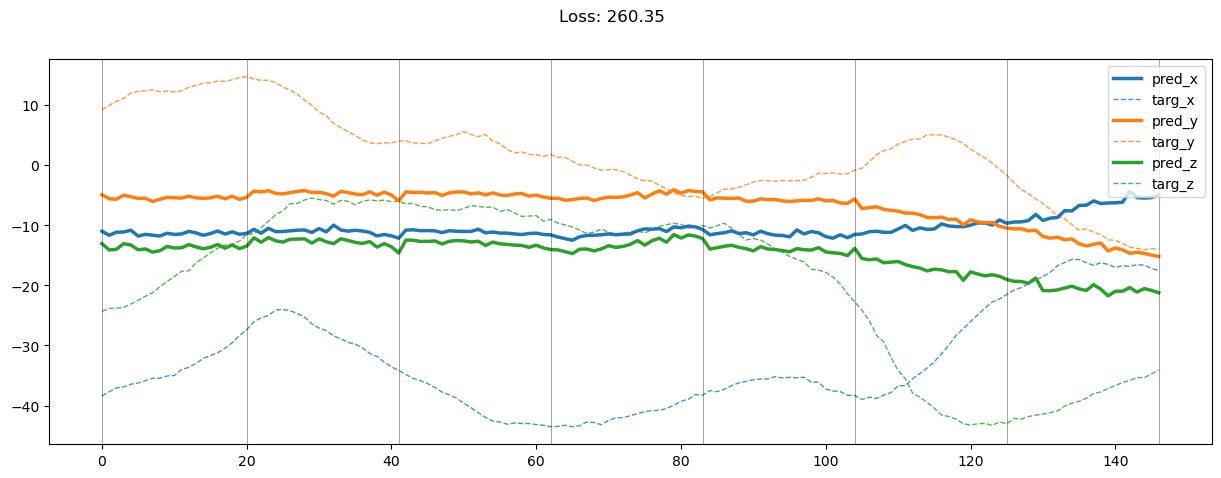

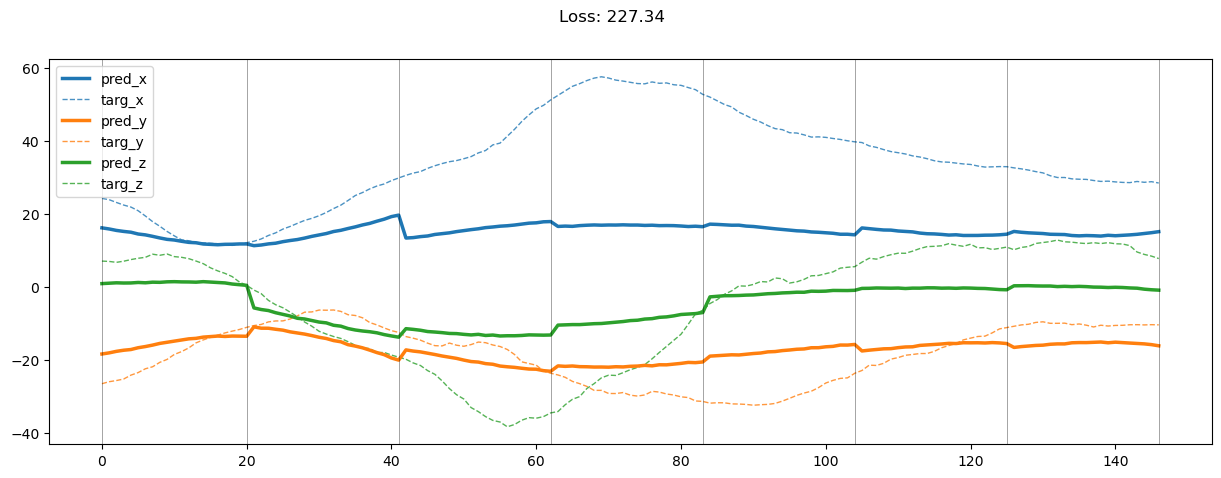

00799: train loss:  268.184, imu loss:  0.677, mag loss:  267.507
       valid loss:  278.850, imu loss:  0.510, mag loss:  278.340
00819: train loss:  261.675, imu loss:  0.677, mag loss:  260.997
       valid loss:  273.399, imu loss:  0.510, mag loss:  272.890
00839: train loss:  252.352, imu loss:  0.675, mag loss:  251.677
       valid loss:  265.609, imu loss:  0.510, mag loss:  265.099
00859: train loss:  248.296, imu loss:  0.674, mag loss:  247.622
       valid loss:  258.874, imu loss:  0.510, mag loss:  258.364
00879: train loss:  239.409, imu loss:  0.683, mag loss:  238.726
       valid loss:  251.232, imu loss:  0.510, mag loss:  250.722
00899: train loss:  230.377, imu loss:  0.679, mag loss:  229.698
       valid loss:  245.087, imu loss:  0.510, mag loss:  244.578
00919: train loss:  222.949, imu loss:  0.677, mag loss:  222.272
       valid loss:  239.768, imu loss:  0.510, mag loss:  239.258
00939: train loss:  218.105, imu loss:  0.679, mag loss:  217.426
       val

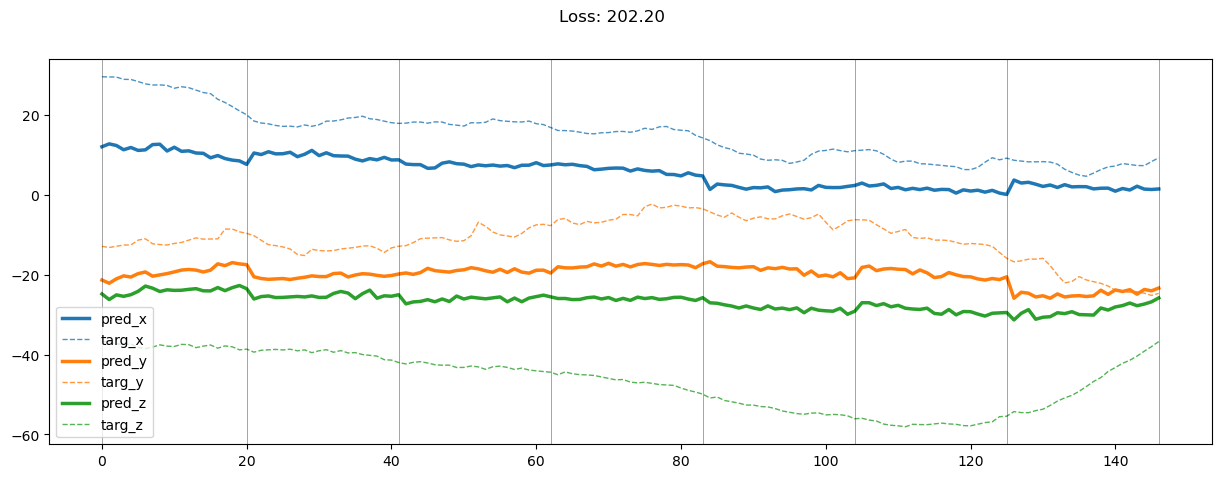

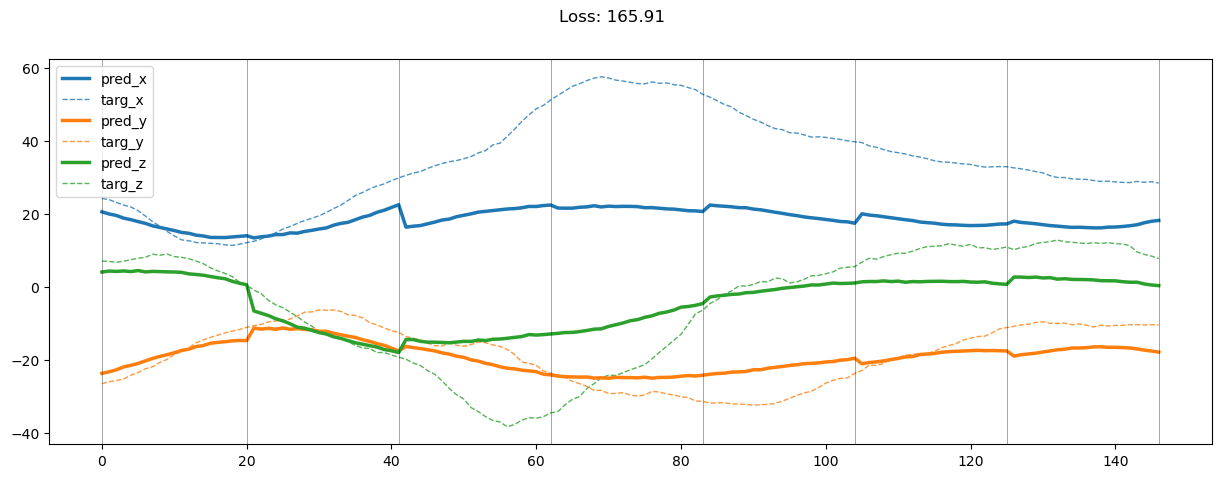

00999: train loss:  198.211, imu loss:  0.676, mag loss:  197.534
       valid loss:  214.146, imu loss:  0.510, mag loss:  213.636
01019: train loss:  192.650, imu loss:  0.679, mag loss:  191.971
       valid loss:  208.707, imu loss:  0.510, mag loss:  208.198
01039: train loss:  185.699, imu loss:  0.682, mag loss:  185.017
       valid loss:  203.570, imu loss:  0.510, mag loss:  203.060
01059: train loss:  180.120, imu loss:  0.683, mag loss:  179.437
       valid loss:  198.607, imu loss:  0.510, mag loss:  198.098
01079: train loss:  175.034, imu loss:  0.673, mag loss:  174.361
       valid loss:  193.696, imu loss:  0.510, mag loss:  193.186
01099: train loss:  166.850, imu loss:  0.669, mag loss:  166.181
       valid loss:  188.462, imu loss:  0.510, mag loss:  187.953
01119: train loss:  162.721, imu loss:  0.676, mag loss:  162.045
       valid loss:  184.415, imu loss:  0.510, mag loss:  183.905
01139: train loss:  156.587, imu loss:  0.677, mag loss:  155.911
       val

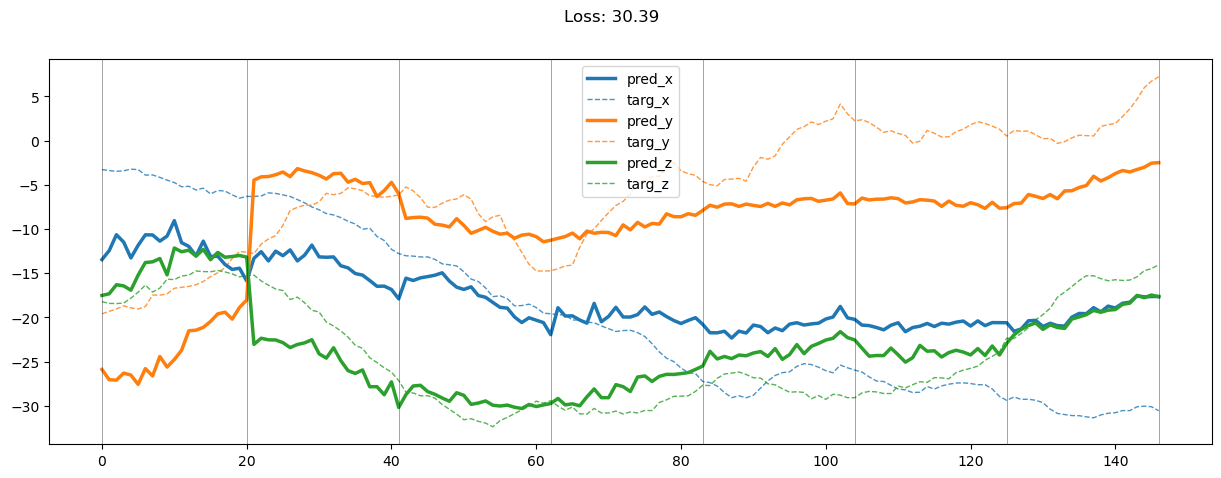

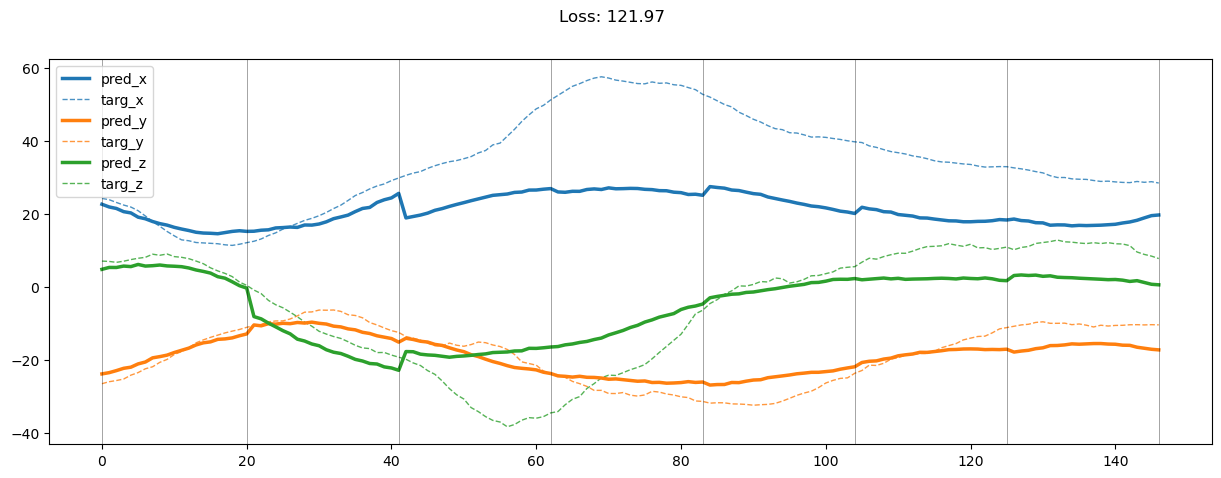

01199: train loss:  138.008, imu loss:  0.690, mag loss:  137.319
       valid loss:  161.247, imu loss:  0.510, mag loss:  160.737
01219: train loss:  134.684, imu loss:  0.678, mag loss:  134.006
       valid loss:  158.469, imu loss:  0.510, mag loss:  157.960
01239: train loss:  128.890, imu loss:  0.682, mag loss:  128.209
       valid loss:  152.440, imu loss:  0.510, mag loss:  151.930
01259: train loss:  125.097, imu loss:  0.674, mag loss:  124.423
       valid loss:  150.013, imu loss:  0.510, mag loss:  149.503
01279: train loss:  117.343, imu loss:  0.679, mag loss:  116.663
       valid loss:  143.663, imu loss:  0.510, mag loss:  143.153
01299: train loss:  114.925, imu loss:  0.678, mag loss:  114.247
       valid loss:  141.985, imu loss:  0.510, mag loss:  141.475
01319: train loss:  110.402, imu loss:  0.676, mag loss:  109.726
       valid loss:  135.443, imu loss:  0.510, mag loss:  134.933
01339: train loss:  106.868, imu loss:  0.684, mag loss:  106.184
       val

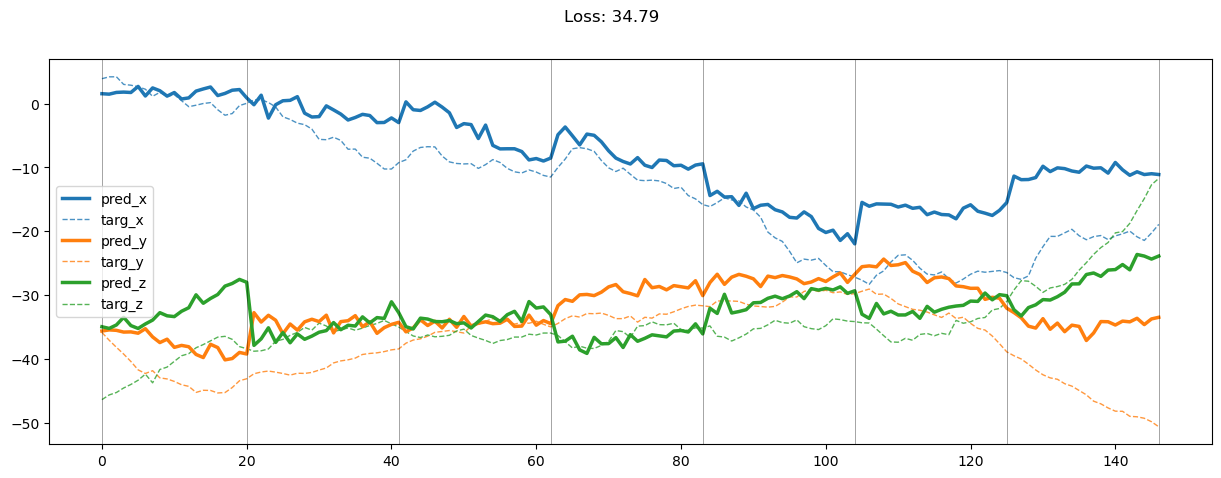

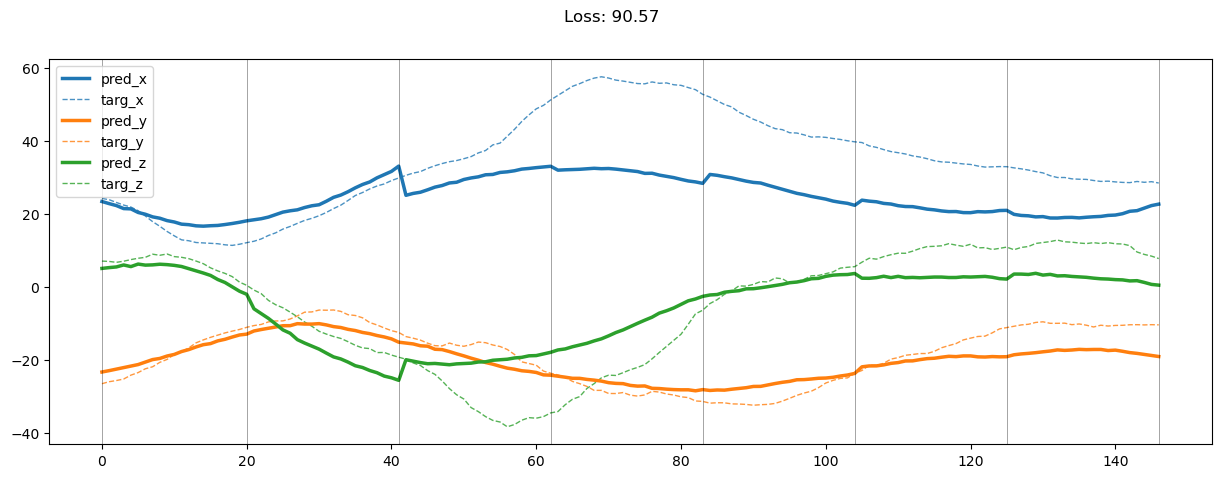

01399: train loss:  92.041, imu loss:  0.676, mag loss:  91.365
       valid loss:  122.923, imu loss:  0.510, mag loss:  122.413
01419: train loss:  86.921, imu loss:  0.676, mag loss:  86.245
       valid loss:  119.205, imu loss:  0.510, mag loss:  118.695
01439: train loss:  83.646, imu loss:  0.676, mag loss:  82.970
       valid loss:  115.511, imu loss:  0.510, mag loss:  115.002
01459: train loss:  80.019, imu loss:  0.681, mag loss:  79.338
       valid loss:  113.601, imu loss:  0.510, mag loss:  113.092
01479: train loss:  76.314, imu loss:  0.684, mag loss:  75.630
       valid loss:  109.642, imu loss:  0.510, mag loss:  109.133
01499: train loss:  73.311, imu loss:  0.679, mag loss:  72.632
       valid loss:  107.565, imu loss:  0.510, mag loss:  107.056
01519: train loss:  69.802, imu loss:  0.681, mag loss:  69.121
       valid loss:  104.157, imu loss:  0.510, mag loss:  103.648
01539: train loss:  67.124, imu loss:  0.675, mag loss:  66.449
       valid loss:  103.67

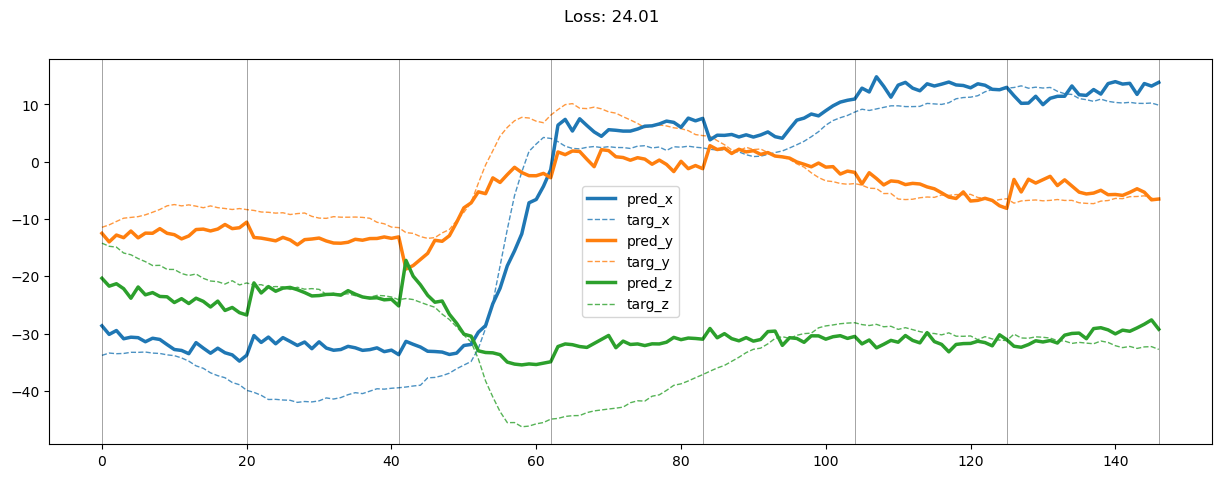

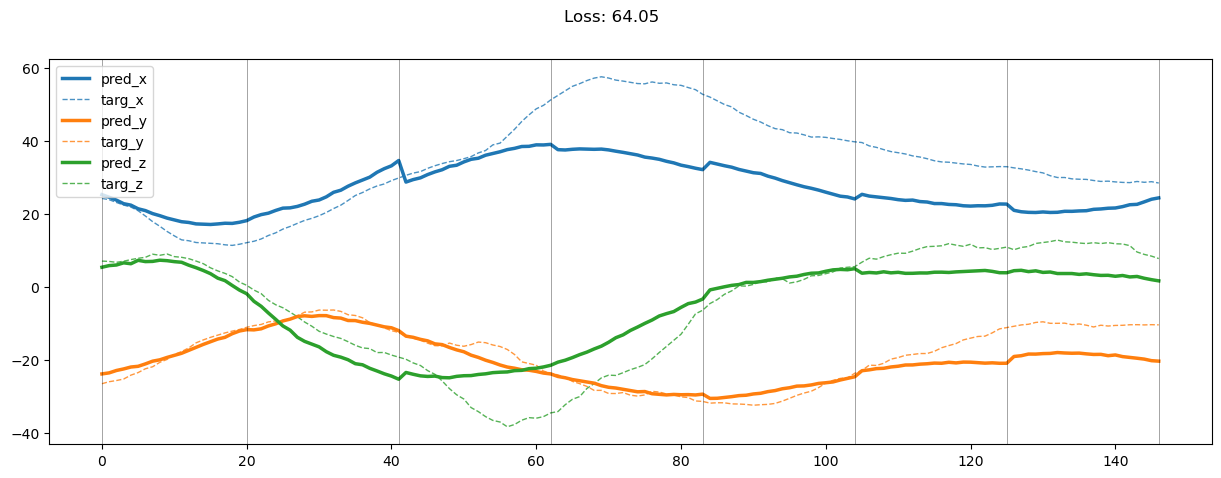

01599: train loss:  57.842, imu loss:  0.676, mag loss:  57.165
       valid loss:  97.965, imu loss:  0.510, mag loss:  97.456
01619: train loss:  55.542, imu loss:  0.676, mag loss:  54.866
       valid loss:  92.836, imu loss:  0.510, mag loss:  92.326
01639: train loss:  52.803, imu loss:  0.675, mag loss:  52.128
       valid loss:  95.194, imu loss:  0.510, mag loss:  94.685
01659: train loss:  50.514, imu loss:  0.679, mag loss:  49.835
       valid loss:  89.823, imu loss:  0.510, mag loss:  89.313
01679: train loss:  49.500, imu loss:  0.679, mag loss:  48.821
       valid loss:  89.362, imu loss:  0.510, mag loss:  88.853
01699: train loss:  46.591, imu loss:  0.678, mag loss:  45.913
       valid loss:  87.297, imu loss:  0.510, mag loss:  86.787
01719: train loss:  44.851, imu loss:  0.679, mag loss:  44.172
       valid loss:  88.810, imu loss:  0.510, mag loss:  88.300
01739: train loss:  43.213, imu loss:  0.679, mag loss:  42.534
       valid loss:  85.966, imu loss:  0

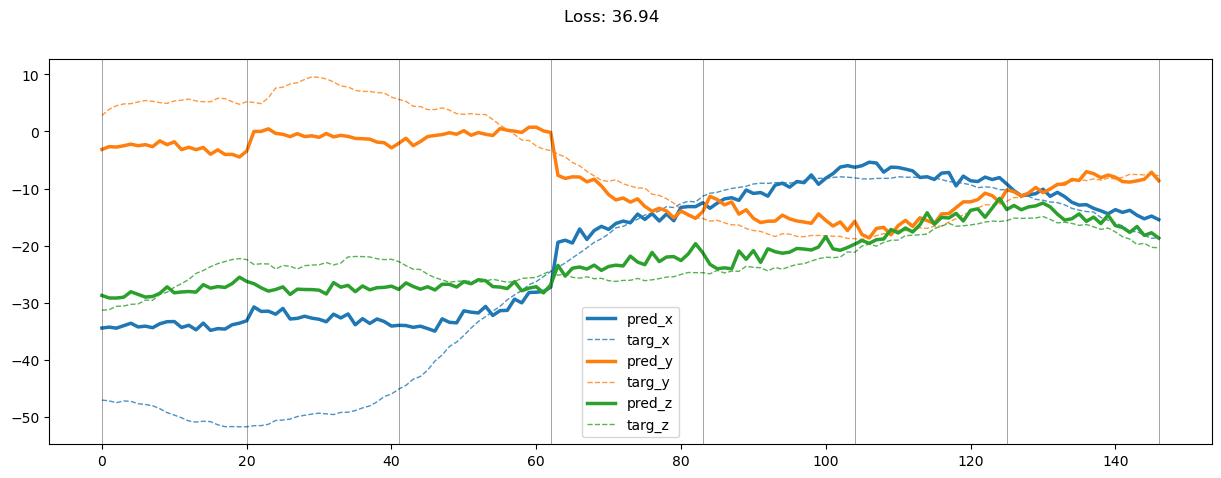

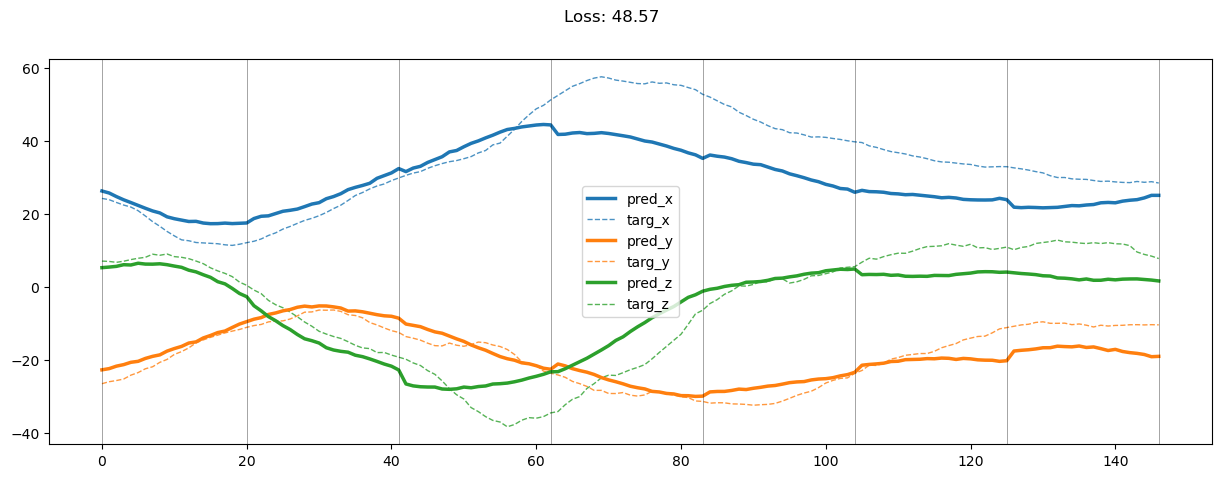

01799: train loss:  37.635, imu loss:  0.672, mag loss:  36.963
       valid loss:  82.691, imu loss:  0.510, mag loss:  82.182
01819: train loss:  36.030, imu loss:  0.680, mag loss:  35.350
       valid loss:  87.729, imu loss:  0.510, mag loss:  87.219
01839: train loss:  34.484, imu loss:  0.673, mag loss:  33.811
       valid loss:  81.734, imu loss:  0.510, mag loss:  81.225
01859: train loss:  32.729, imu loss:  0.682, mag loss:  32.047
       valid loss:  81.775, imu loss:  0.510, mag loss:  81.265
01879: train loss:  31.401, imu loss:  0.676, mag loss:  30.725
       valid loss:  84.126, imu loss:  0.510, mag loss:  83.616
01899: train loss:  30.021, imu loss:  0.675, mag loss:  29.346
       valid loss:  80.769, imu loss:  0.510, mag loss:  80.259
01919: train loss:  29.474, imu loss:  0.674, mag loss:  28.800
       valid loss:  77.973, imu loss:  0.510, mag loss:  77.464
01939: train loss:  28.269, imu loss:  0.676, mag loss:  27.593
       valid loss:  79.094, imu loss:  0

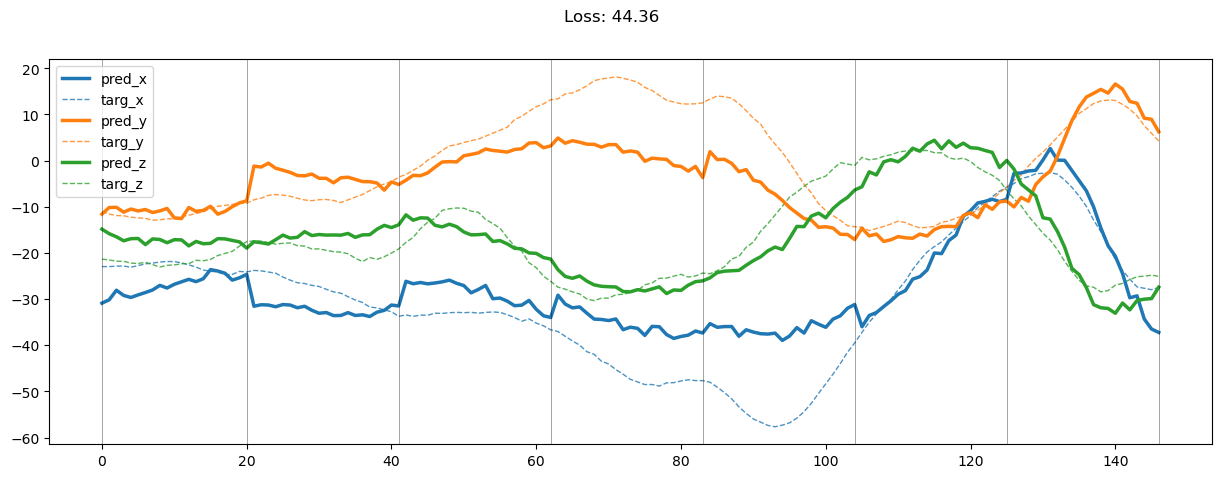

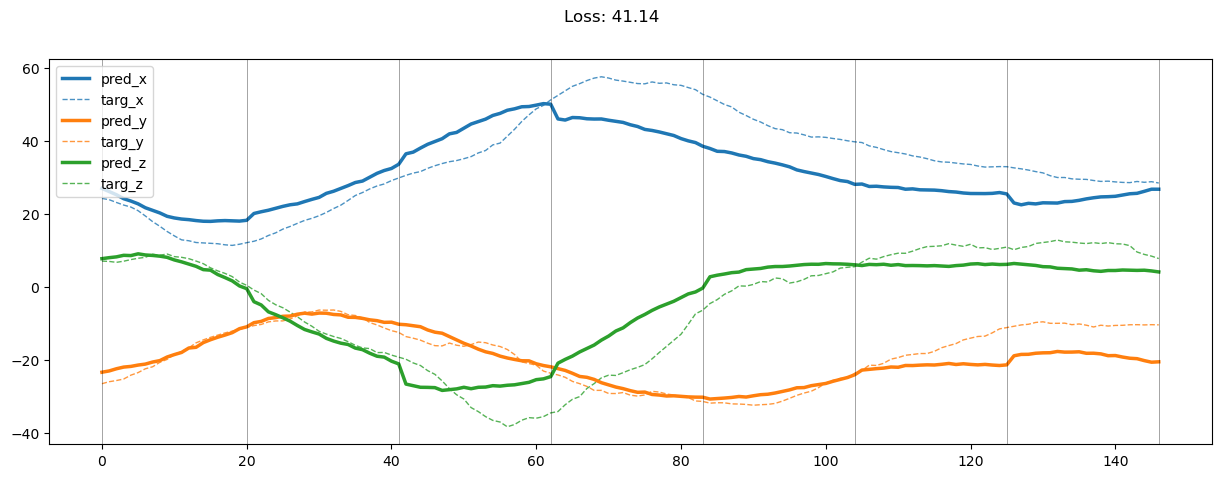

01999: train loss:  24.971, imu loss:  0.672, mag loss:  24.299
       valid loss:  77.276, imu loss:  0.510, mag loss:  76.767
02019: train loss:  24.429, imu loss:  0.684, mag loss:  23.745
       valid loss:  76.635, imu loss:  0.510, mag loss:  76.126
02039: train loss:  23.877, imu loss:  0.672, mag loss:  23.206
       valid loss:  75.902, imu loss:  0.510, mag loss:  75.392
02059: train loss:  22.310, imu loss:  0.674, mag loss:  21.636
       valid loss:  83.440, imu loss:  0.510, mag loss:  82.930
02079: train loss:  21.744, imu loss:  0.673, mag loss:  21.072
       valid loss:  77.273, imu loss:  0.510, mag loss:  76.763
02099: train loss:  20.900, imu loss:  0.678, mag loss:  20.222
       valid loss:  76.935, imu loss:  0.510, mag loss:  76.425
02119: train loss:  20.438, imu loss:  0.670, mag loss:  19.768
       valid loss:  77.412, imu loss:  0.510, mag loss:  76.902
02139: train loss:  20.146, imu loss:  0.668, mag loss:  19.478
       valid loss:  77.142, imu loss:  0

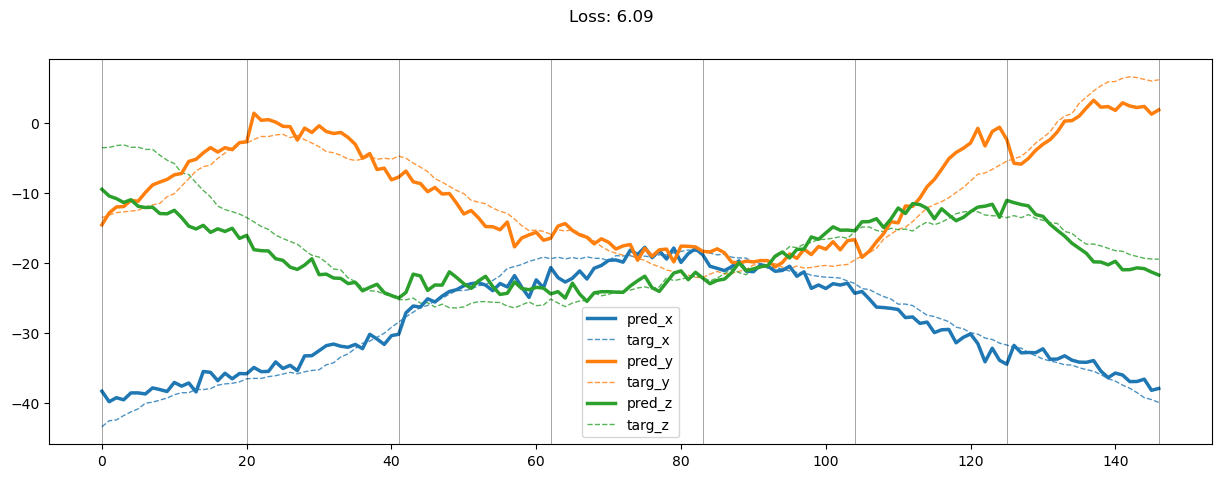

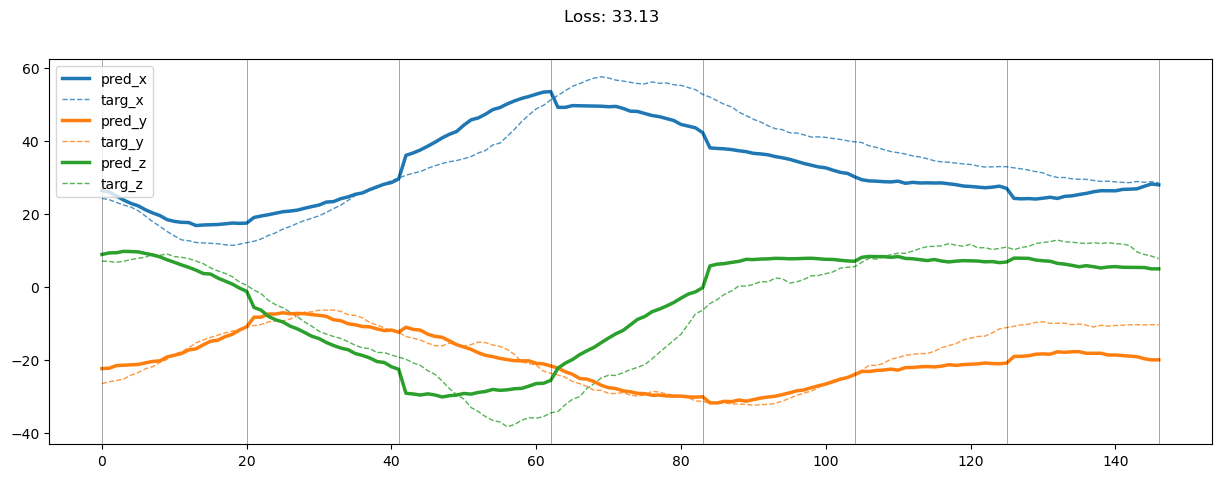

02199: train loss:  18.111, imu loss:  0.683, mag loss:  17.428
       valid loss:  74.973, imu loss:  0.510, mag loss:  74.464
02219: train loss:  17.426, imu loss:  0.672, mag loss:  16.755
       valid loss:  75.339, imu loss:  0.510, mag loss:  74.830
02239: train loss:  16.950, imu loss:  0.674, mag loss:  16.275
       valid loss:  77.674, imu loss:  0.510, mag loss:  77.165
02259: train loss:  16.145, imu loss:  0.678, mag loss:  15.467
       valid loss:  76.086, imu loss:  0.510, mag loss:  75.577
02279: train loss:  15.971, imu loss:  0.671, mag loss:  15.300
       valid loss:  76.173, imu loss:  0.510, mag loss:  75.663
02299: train loss:  15.656, imu loss:  0.671, mag loss:  14.984
       valid loss:  79.101, imu loss:  0.510, mag loss:  78.592
02319: train loss:  15.111, imu loss:  0.681, mag loss:  14.430
       valid loss:  74.755, imu loss:  0.510, mag loss:  74.246
02339: train loss:  14.561, imu loss:  0.677, mag loss:  13.884
       valid loss:  72.488, imu loss:  0

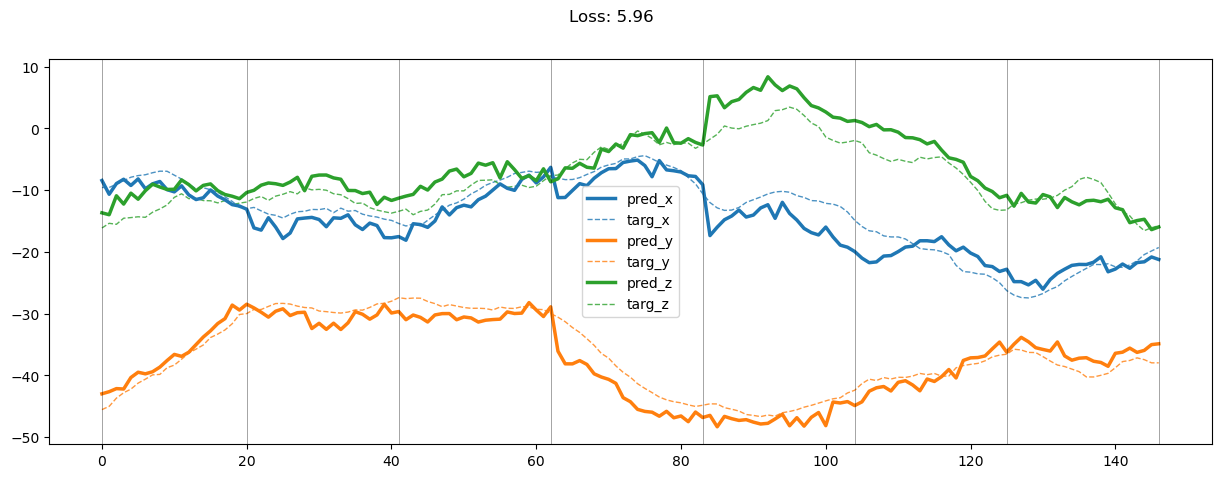

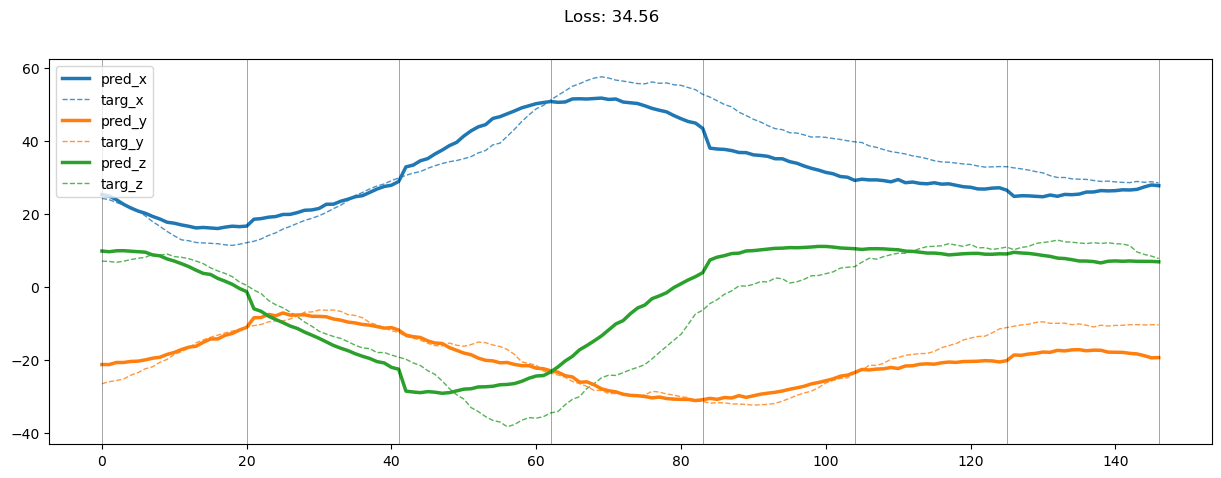

02399: train loss:  13.626, imu loss:  0.673, mag loss:  12.953
       valid loss:  77.636, imu loss:  0.509, mag loss:  77.126
02419: train loss:  13.257, imu loss:  0.671, mag loss:  12.586
       valid loss:  73.155, imu loss:  0.509, mag loss:  72.646
02439: train loss:  12.822, imu loss:  0.678, mag loss:  12.145
       valid loss:  76.139, imu loss:  0.510, mag loss:  75.629
02459: train loss:  12.352, imu loss:  0.677, mag loss:  11.675
       valid loss:  76.360, imu loss:  0.510, mag loss:  75.850
02479: train loss:  12.374, imu loss:  0.682, mag loss:  11.692
       valid loss:  74.141, imu loss:  0.510, mag loss:  73.632
02499: train loss:  11.875, imu loss:  0.666, mag loss:  11.210
       valid loss:  74.889, imu loss:  0.509, mag loss:  74.379
02519: train loss:  11.821, imu loss:  0.678, mag loss:  11.143
       valid loss:  71.718, imu loss:  0.509, mag loss:  71.208
02539: train loss:  11.267, imu loss:  0.672, mag loss:  10.595
       valid loss:  73.628, imu loss:  0

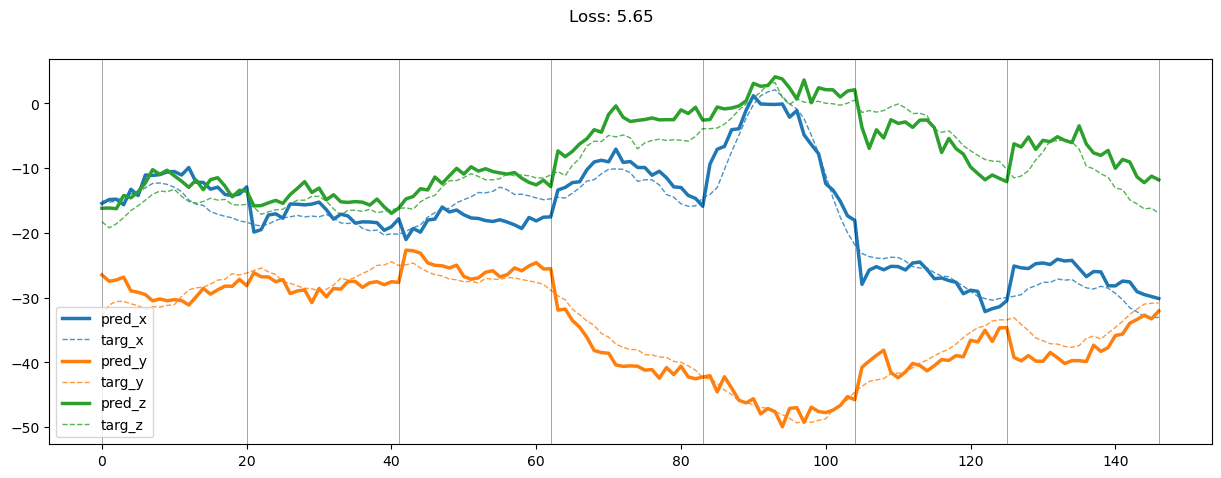

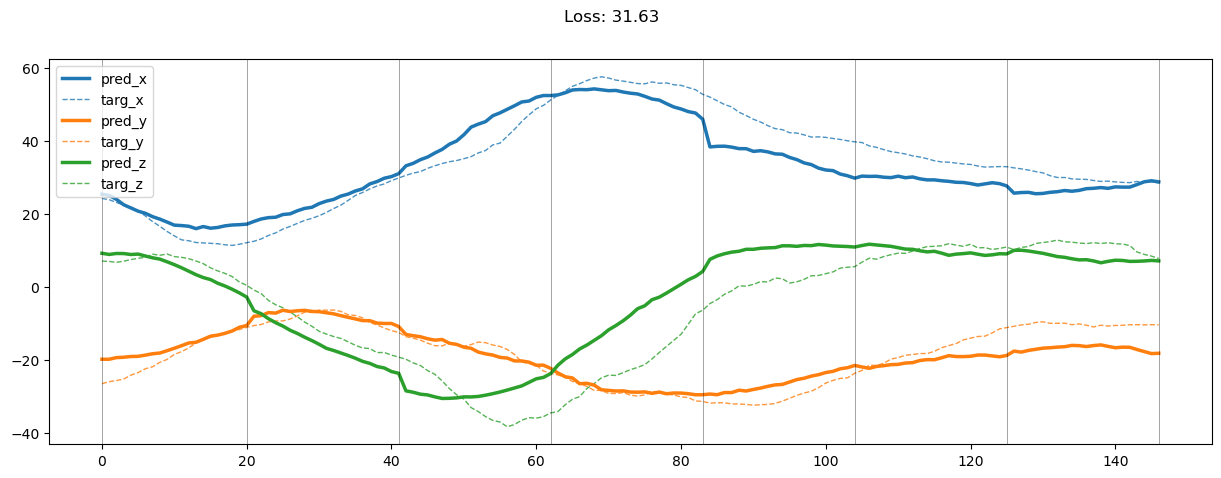

02599: train loss:  10.657, imu loss:  0.674, mag loss:  9.983
       valid loss:  74.004, imu loss:  0.509, mag loss:  73.495
02619: train loss:  10.193, imu loss:  0.671, mag loss:  9.522
       valid loss:  73.864, imu loss:  0.509, mag loss:  73.355
02639: train loss:  10.061, imu loss:  0.677, mag loss:  9.384
       valid loss:  71.263, imu loss:  0.509, mag loss:  70.754
02659: train loss:  9.731, imu loss:  0.669, mag loss:  9.061
       valid loss:  73.197, imu loss:  0.509, mag loss:  72.687
02679: train loss:  9.409, imu loss:  0.680, mag loss:  8.729
       valid loss:  76.081, imu loss:  0.509, mag loss:  75.572
02699: train loss:  9.457, imu loss:  0.669, mag loss:  8.789
       valid loss:  73.744, imu loss:  0.509, mag loss:  73.235
02719: train loss:  8.987, imu loss:  0.677, mag loss:  8.310
       valid loss:  69.115, imu loss:  0.509, mag loss:  68.606
02739: train loss:  9.009, imu loss:  0.671, mag loss:  8.337
       valid loss:  74.291, imu loss:  0.509, mag los

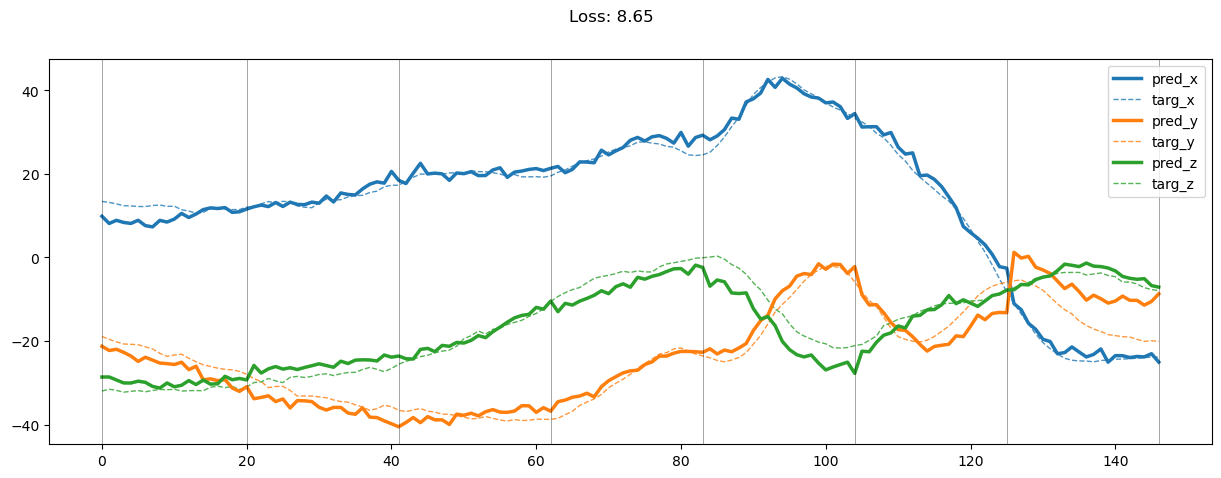

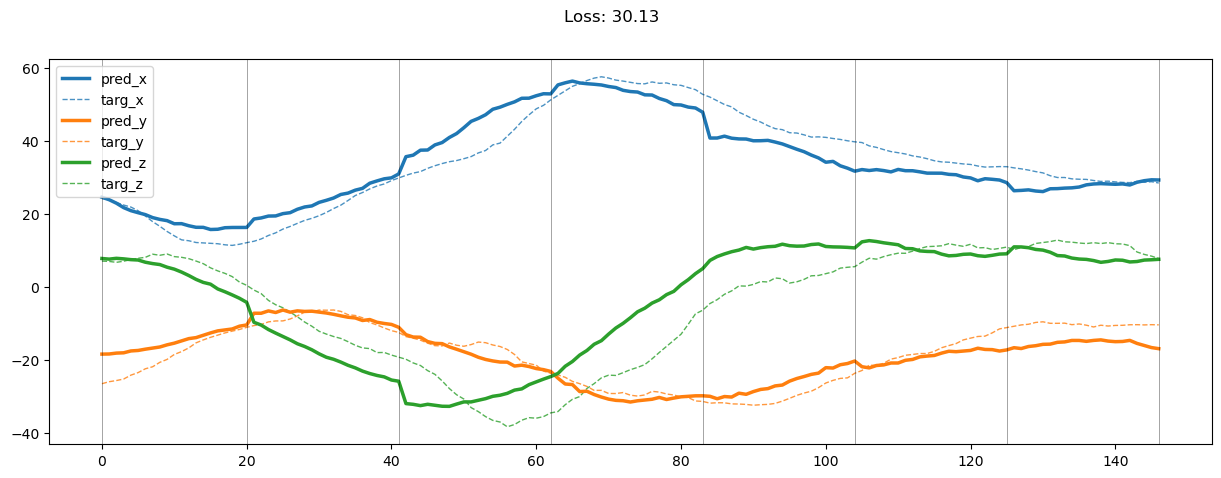

02799: train loss:  8.632, imu loss:  0.673, mag loss:  7.959
       valid loss:  75.524, imu loss:  0.509, mag loss:  75.015
02819: train loss:  8.522, imu loss:  0.669, mag loss:  7.853
       valid loss:  73.004, imu loss:  0.509, mag loss:  72.495
02839: train loss:  8.143, imu loss:  0.673, mag loss:  7.470
       valid loss:  73.512, imu loss:  0.509, mag loss:  73.002
02859: train loss:  8.184, imu loss:  0.679, mag loss:  7.506
       valid loss:  73.051, imu loss:  0.509, mag loss:  72.542
02879: train loss:  7.768, imu loss:  0.675, mag loss:  7.093
       valid loss:  75.356, imu loss:  0.509, mag loss:  74.846
02899: train loss:  7.612, imu loss:  0.674, mag loss:  6.938
       valid loss:  71.900, imu loss:  0.509, mag loss:  71.390
02919: train loss:  7.688, imu loss:  0.669, mag loss:  7.019
       valid loss:  72.657, imu loss:  0.509, mag loss:  72.147
02939: train loss:  7.322, imu loss:  0.676, mag loss:  6.646
       valid loss:  71.287, imu loss:  0.509, mag loss: 

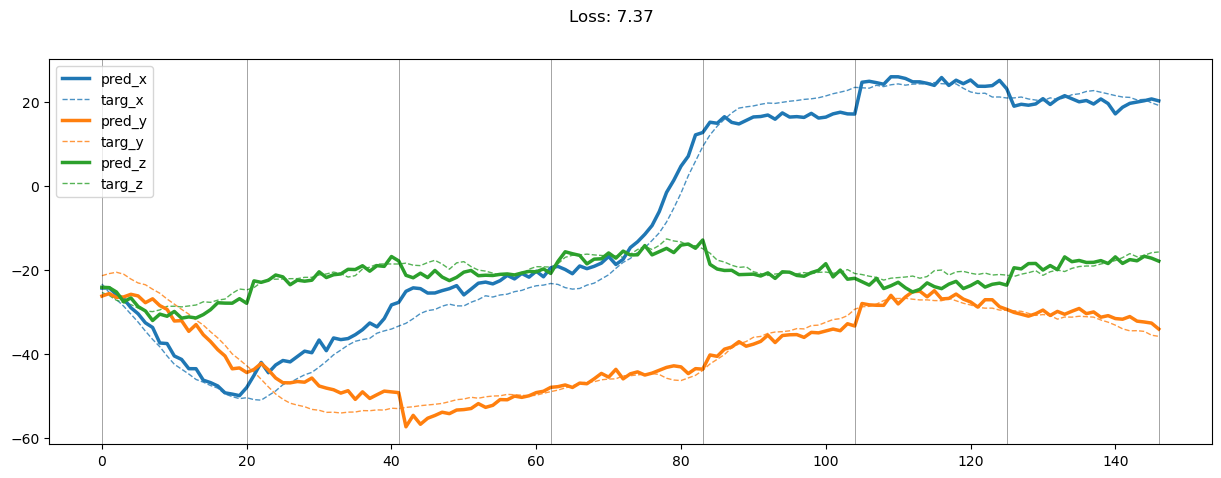

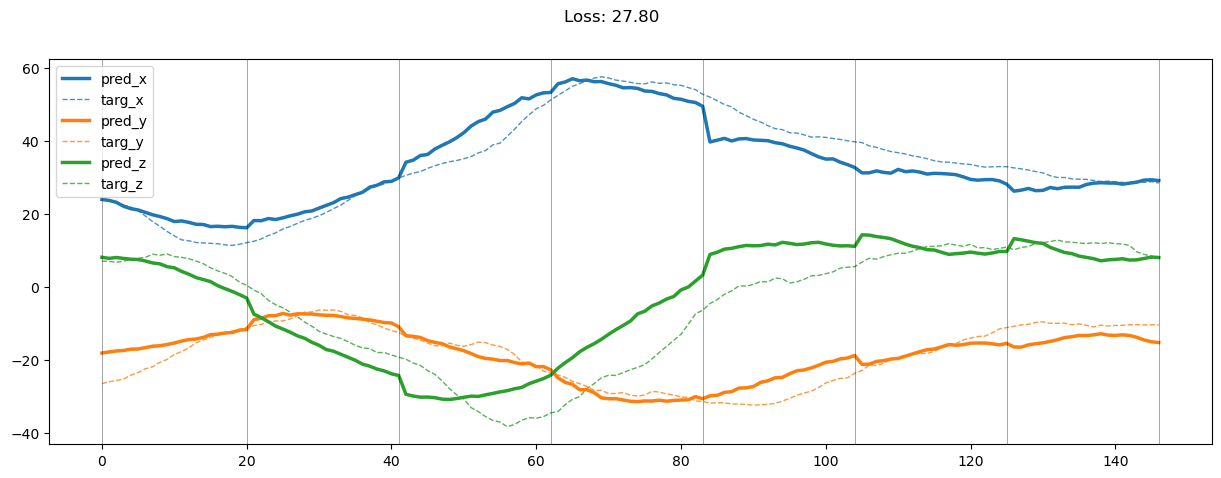

02999: train loss:  6.917, imu loss:  0.671, mag loss:  6.246
       valid loss:  71.473, imu loss:  0.509, mag loss:  70.964
03019: train loss:  6.931, imu loss:  0.677, mag loss:  6.254
       valid loss:  72.028, imu loss:  0.509, mag loss:  71.519
03039: train loss:  6.966, imu loss:  0.671, mag loss:  6.295
       valid loss:  70.611, imu loss:  0.509, mag loss:  70.102
03059: train loss:  6.691, imu loss:  0.671, mag loss:  6.021
       valid loss:  72.095, imu loss:  0.509, mag loss:  71.585
03079: train loss:  6.684, imu loss:  0.670, mag loss:  6.014
       valid loss:  72.194, imu loss:  0.509, mag loss:  71.685
03099: train loss:  6.551, imu loss:  0.678, mag loss:  5.873
       valid loss:  73.082, imu loss:  0.509, mag loss:  72.573
03119: train loss:  6.480, imu loss:  0.678, mag loss:  5.802
       valid loss:  74.688, imu loss:  0.509, mag loss:  74.178
03139: train loss:  6.238, imu loss:  0.672, mag loss:  5.566
       valid loss:  73.183, imu loss:  0.509, mag loss: 

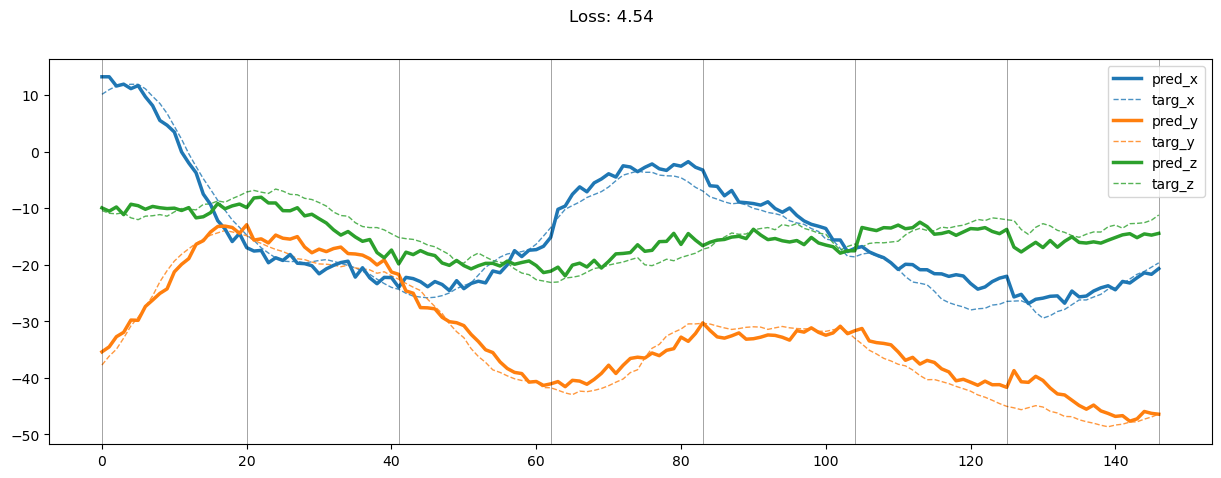

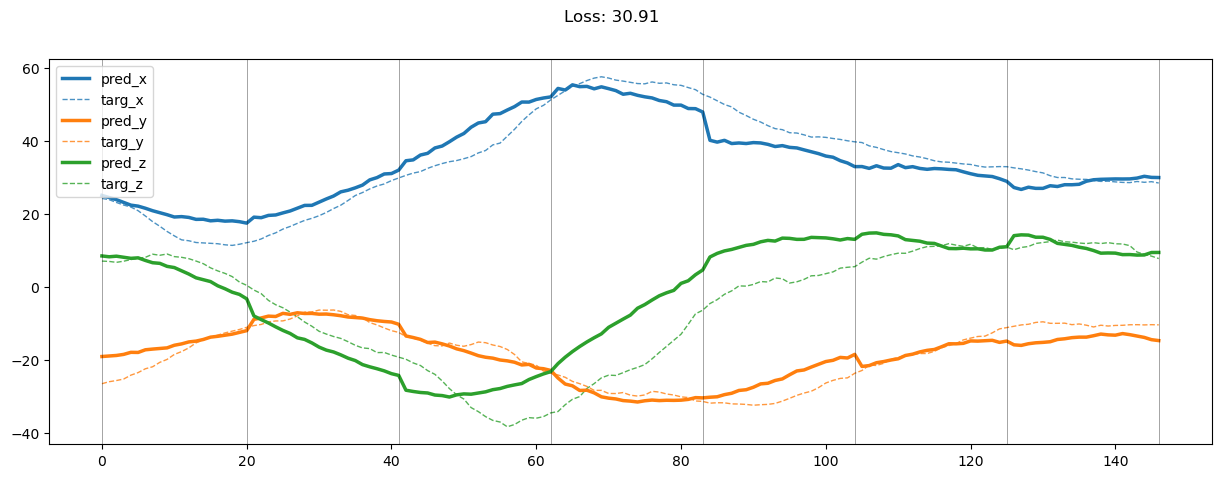

03199: train loss:  6.032, imu loss:  0.681, mag loss:  5.352
       valid loss:  70.901, imu loss:  0.509, mag loss:  70.392
03219: train loss:  6.130, imu loss:  0.677, mag loss:  5.453
       valid loss:  74.180, imu loss:  0.509, mag loss:  73.670
03239: train loss:  5.780, imu loss:  0.680, mag loss:  5.100
       valid loss:  74.368, imu loss:  0.509, mag loss:  73.858
03259: train loss:  5.793, imu loss:  0.672, mag loss:  5.122
       valid loss:  71.934, imu loss:  0.509, mag loss:  71.424
03279: train loss:  5.748, imu loss:  0.667, mag loss:  5.081
       valid loss:  74.499, imu loss:  0.509, mag loss:  73.989
03299: train loss:  5.694, imu loss:  0.668, mag loss:  5.026
       valid loss:  72.769, imu loss:  0.509, mag loss:  72.260
03319: train loss:  5.596, imu loss:  0.671, mag loss:  4.925
       valid loss:  74.576, imu loss:  0.509, mag loss:  74.066
03339: train loss:  5.558, imu loss:  0.669, mag loss:  4.888
       valid loss:  73.241, imu loss:  0.509, mag loss: 

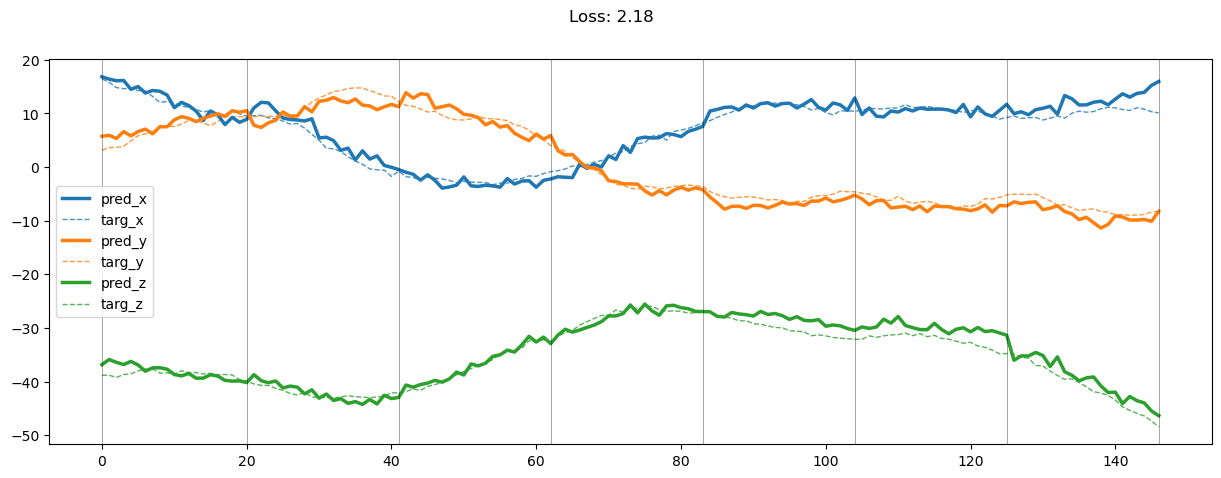

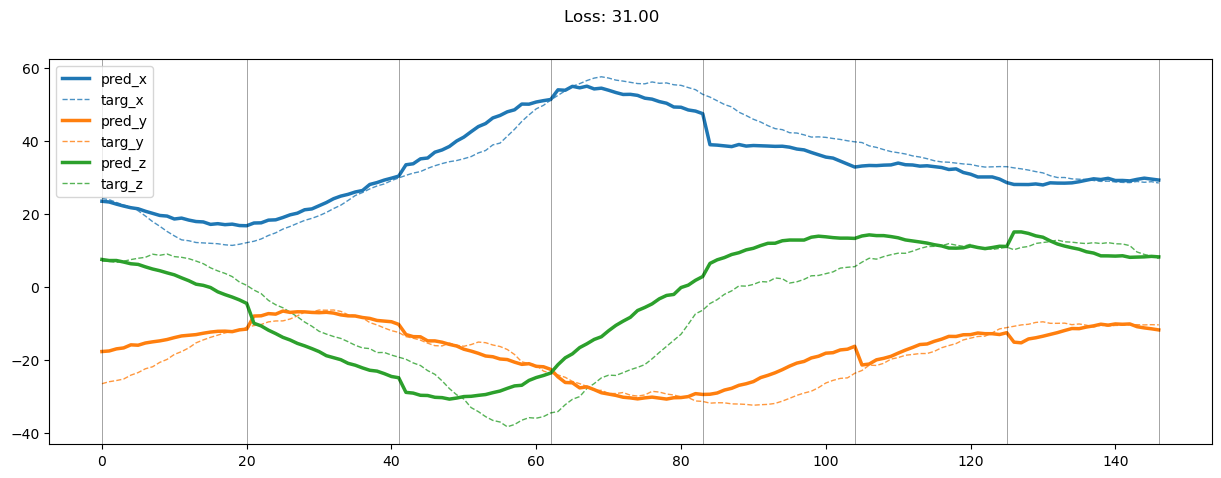

03399: train loss:  5.340, imu loss:  0.678, mag loss:  4.663
       valid loss:  70.378, imu loss:  0.509, mag loss:  69.868
03419: train loss:  5.333, imu loss:  0.676, mag loss:  4.657
       valid loss:  73.546, imu loss:  0.509, mag loss:  73.036
03439: train loss:  5.136, imu loss:  0.673, mag loss:  4.463
       valid loss:  72.531, imu loss:  0.509, mag loss:  72.022
03459: train loss:  5.099, imu loss:  0.673, mag loss:  4.426
       valid loss:  71.583, imu loss:  0.509, mag loss:  71.074
03479: train loss:  5.036, imu loss:  0.677, mag loss:  4.359
       valid loss:  73.292, imu loss:  0.509, mag loss:  72.782
03499: train loss:  5.115, imu loss:  0.669, mag loss:  4.445
       valid loss:  74.813, imu loss:  0.509, mag loss:  74.304
03519: train loss:  4.935, imu loss:  0.671, mag loss:  4.264
       valid loss:  74.103, imu loss:  0.510, mag loss:  73.594
03539: train loss:  4.895, imu loss:  0.671, mag loss:  4.224
       valid loss:  71.250, imu loss:  0.510, mag loss: 

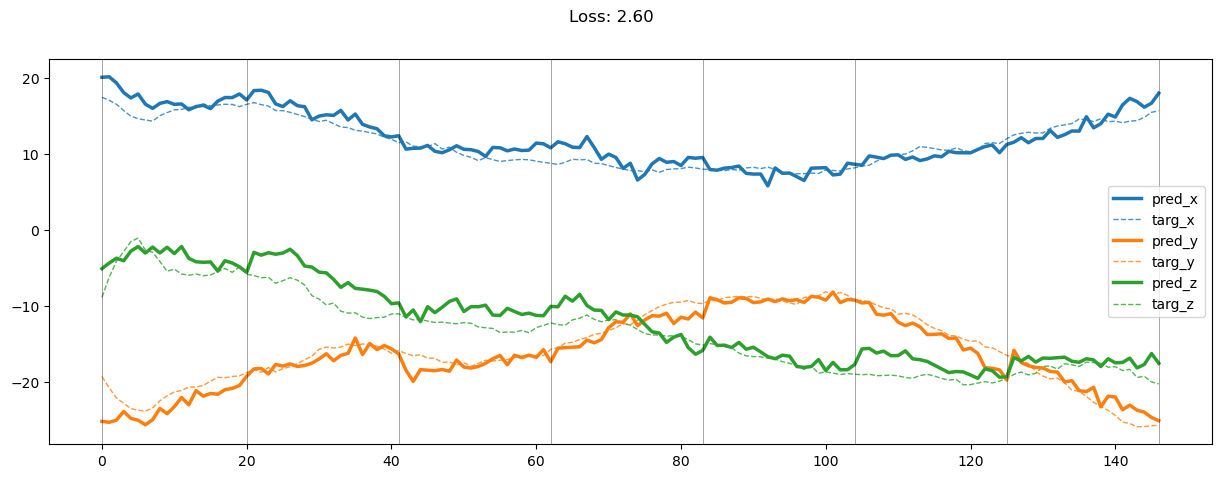

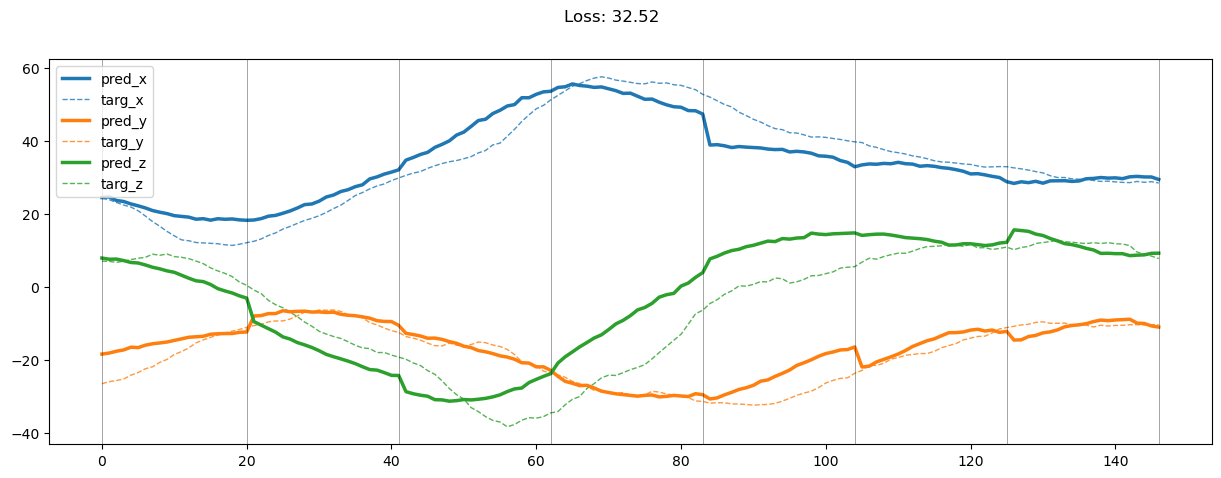

03599: train loss:  4.806, imu loss:  0.675, mag loss:  4.131
       valid loss:  69.926, imu loss:  0.509, mag loss:  69.416
03619: train loss:  4.658, imu loss:  0.673, mag loss:  3.985
       valid loss:  72.408, imu loss:  0.509, mag loss:  71.898
03639: train loss:  4.779, imu loss:  0.667, mag loss:  4.111
       valid loss:  74.362, imu loss:  0.509, mag loss:  73.852
03659: train loss:  4.629, imu loss:  0.668, mag loss:  3.961
       valid loss:  73.948, imu loss:  0.509, mag loss:  73.439
03679: train loss:  4.604, imu loss:  0.673, mag loss:  3.931
       valid loss:  72.440, imu loss:  0.509, mag loss:  71.931
03699: train loss:  4.479, imu loss:  0.669, mag loss:  3.811
       valid loss:  72.157, imu loss:  0.509, mag loss:  71.648
03719: train loss:  4.424, imu loss:  0.672, mag loss:  3.752
       valid loss:  73.545, imu loss:  0.510, mag loss:  73.035
03739: train loss:  4.502, imu loss:  0.676, mag loss:  3.826
       valid loss:  76.495, imu loss:  0.510, mag loss: 

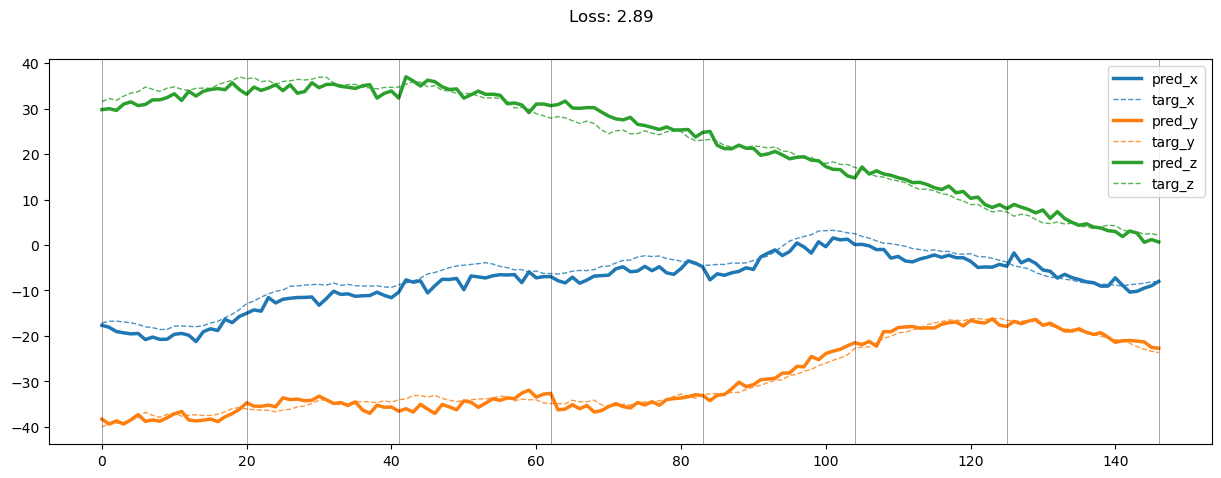

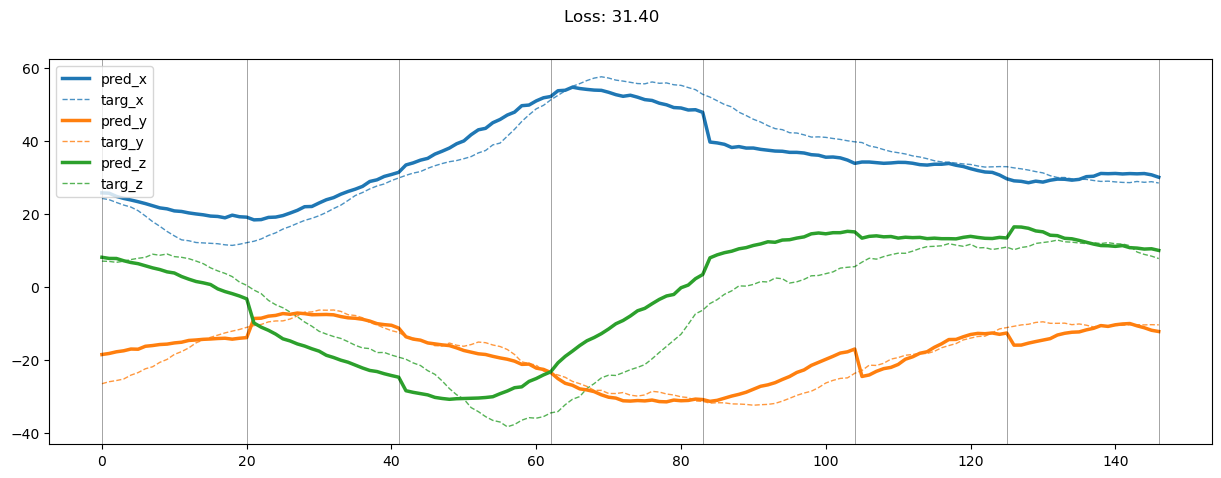

03799: train loss:  4.297, imu loss:  0.666, mag loss:  3.632
       valid loss:  76.177, imu loss:  0.509, mag loss:  75.667
03819: train loss:  4.318, imu loss:  0.671, mag loss:  3.647
       valid loss:  74.151, imu loss:  0.510, mag loss:  73.641
03839: train loss:  4.227, imu loss:  0.677, mag loss:  3.551
       valid loss:  76.547, imu loss:  0.509, mag loss:  76.037
03859: train loss:  4.266, imu loss:  0.668, mag loss:  3.598
       valid loss:  74.532, imu loss:  0.510, mag loss:  74.023
03879: train loss:  4.163, imu loss:  0.669, mag loss:  3.494
       valid loss:  75.858, imu loss:  0.509, mag loss:  75.349
03899: train loss:  4.140, imu loss:  0.668, mag loss:  3.471
       valid loss:  73.671, imu loss:  0.509, mag loss:  73.161
03919: train loss:  4.141, imu loss:  0.670, mag loss:  3.471
       valid loss:  73.770, imu loss:  0.510, mag loss:  73.260
03939: train loss:  4.069, imu loss:  0.668, mag loss:  3.401
       valid loss:  72.524, imu loss:  0.510, mag loss: 

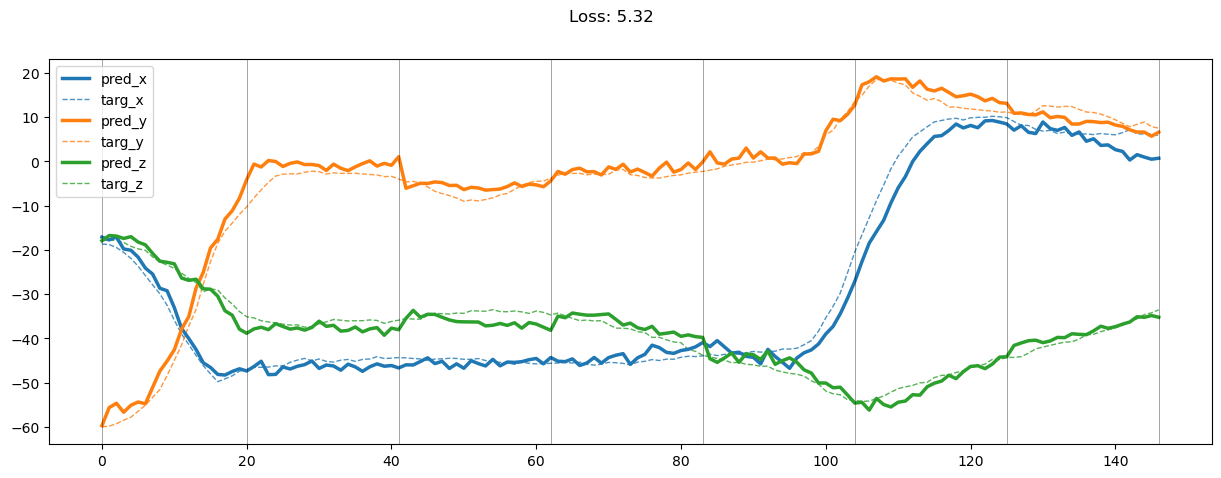

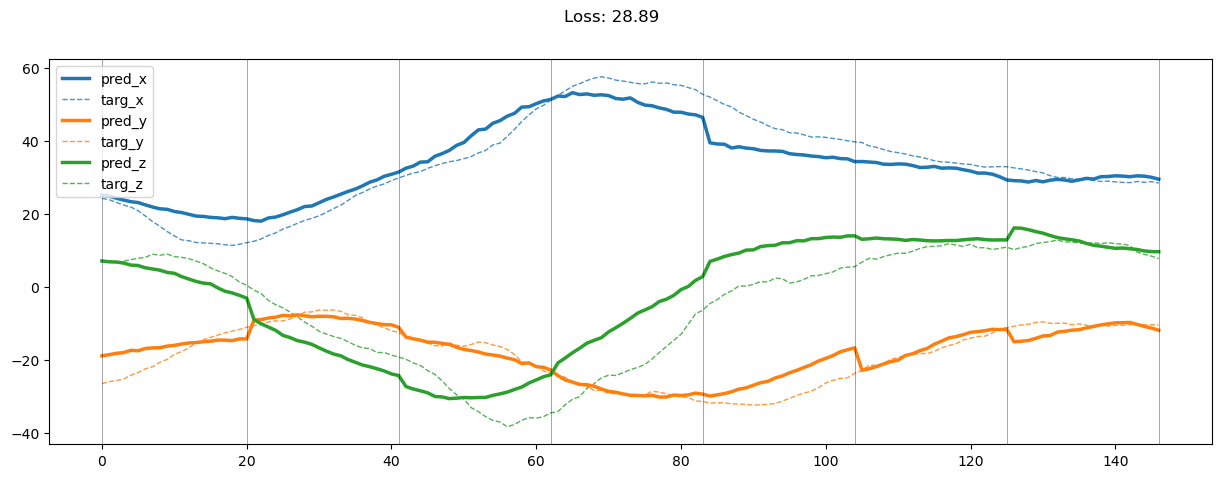

03999: train loss:  3.961, imu loss:  0.668, mag loss:  3.293
       valid loss:  74.692, imu loss:  0.509, mag loss:  74.182
04019: train loss:  3.866, imu loss:  0.669, mag loss:  3.198
       valid loss:  73.978, imu loss:  0.509, mag loss:  73.468
04039: train loss:  3.924, imu loss:  0.662, mag loss:  3.261
       valid loss:  75.716, imu loss:  0.510, mag loss:  75.206
04059: train loss:  3.875, imu loss:  0.670, mag loss:  3.205
       valid loss:  72.430, imu loss:  0.510, mag loss:  71.921
04079: train loss:  3.860, imu loss:  0.666, mag loss:  3.194
       valid loss:  72.665, imu loss:  0.510, mag loss:  72.156
04099: train loss:  3.834, imu loss:  0.664, mag loss:  3.169
       valid loss:  74.191, imu loss:  0.510, mag loss:  73.681
04119: train loss:  3.876, imu loss:  0.666, mag loss:  3.209
       valid loss:  75.584, imu loss:  0.510, mag loss:  75.074
04139: train loss:  3.759, imu loss:  0.663, mag loss:  3.095
       valid loss:  71.640, imu loss:  0.510, mag loss: 

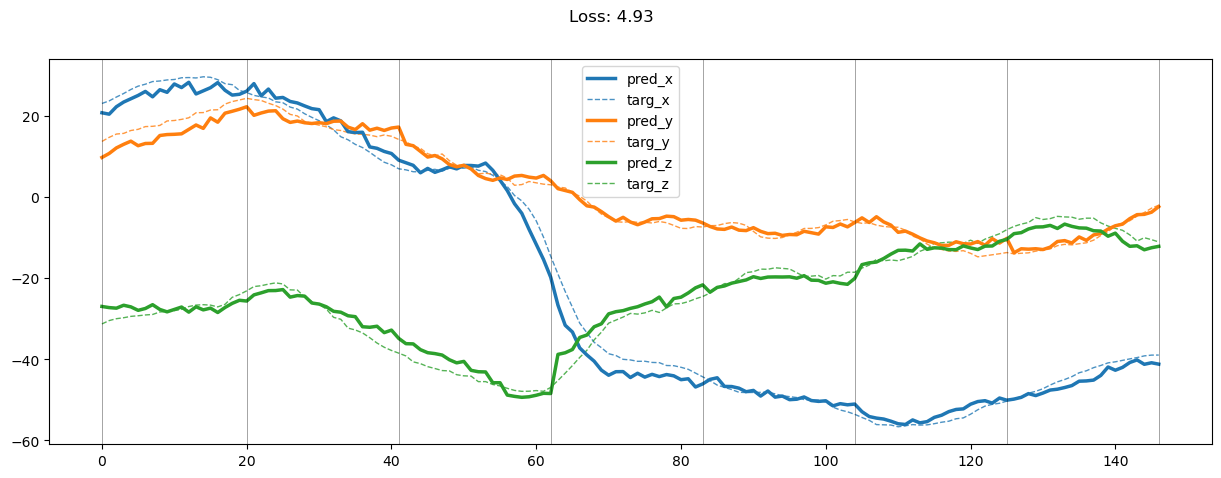

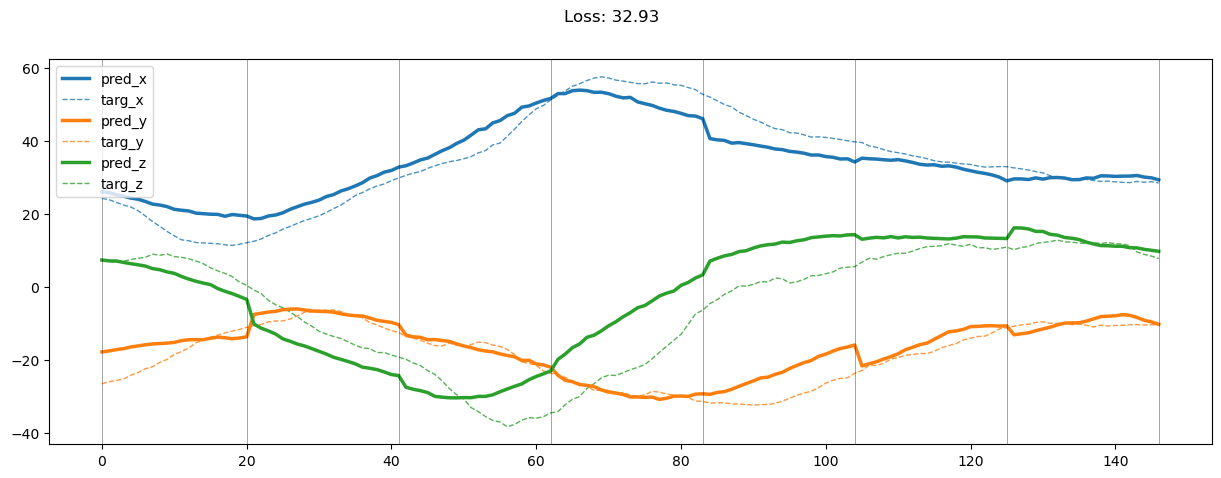

04199: train loss:  3.704, imu loss:  0.670, mag loss:  3.035
       valid loss:  71.970, imu loss:  0.510, mag loss:  71.460
04219: train loss:  3.722, imu loss:  0.666, mag loss:  3.056
       valid loss:  72.064, imu loss:  0.510, mag loss:  71.555
04239: train loss:  3.664, imu loss:  0.671, mag loss:  2.994
       valid loss:  73.987, imu loss:  0.510, mag loss:  73.478
04259: train loss:  3.634, imu loss:  0.667, mag loss:  2.968
       valid loss:  73.594, imu loss:  0.510, mag loss:  73.084
04279: train loss:  3.635, imu loss:  0.682, mag loss:  2.952
       valid loss:  72.554, imu loss:  0.510, mag loss:  72.045
04299: train loss:  3.597, imu loss:  0.674, mag loss:  2.923
       valid loss:  75.854, imu loss:  0.510, mag loss:  75.344
04319: train loss:  3.576, imu loss:  0.671, mag loss:  2.905
       valid loss:  76.009, imu loss:  0.510, mag loss:  75.500
04339: train loss:  3.538, imu loss:  0.672, mag loss:  2.866
       valid loss:  72.892, imu loss:  0.510, mag loss: 

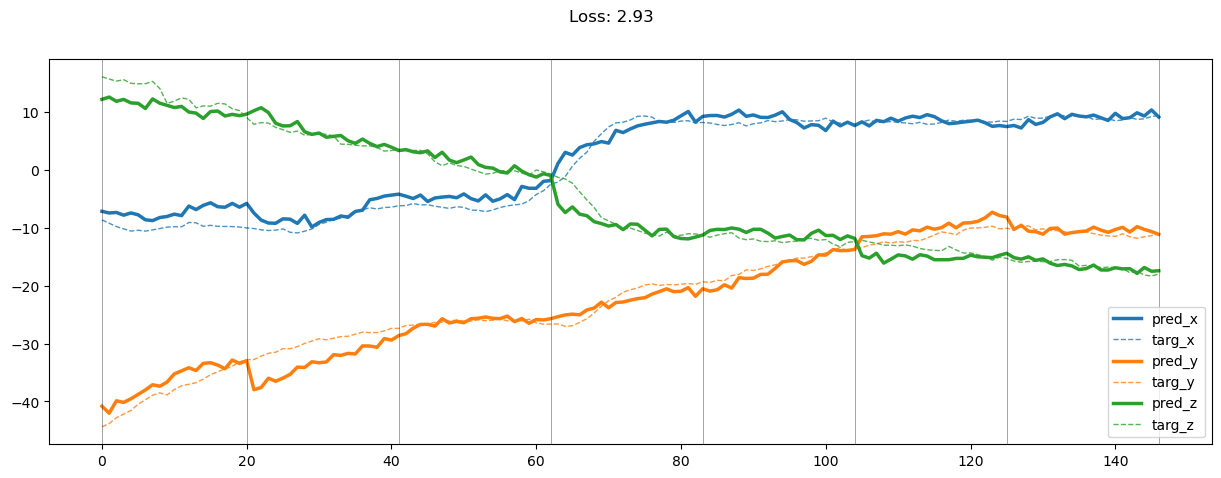

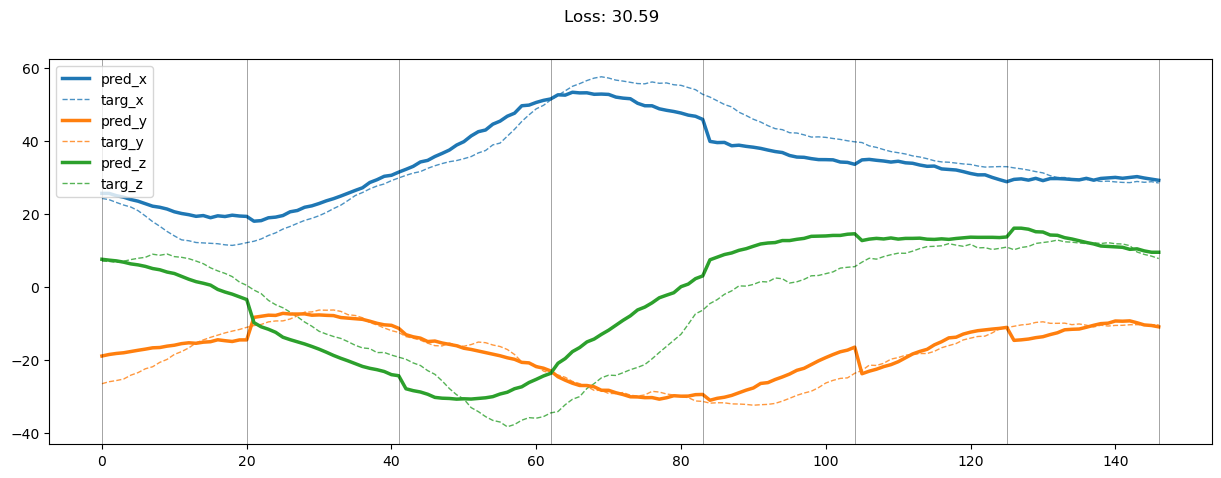

04399: train loss:  3.538, imu loss:  0.673, mag loss:  2.865
       valid loss:  75.360, imu loss:  0.510, mag loss:  74.850
04419: train loss:  3.463, imu loss:  0.671, mag loss:  2.792
       valid loss:  76.148, imu loss:  0.510, mag loss:  75.639
04439: train loss:  3.443, imu loss:  0.672, mag loss:  2.771
       valid loss:  74.049, imu loss:  0.510, mag loss:  73.539
04459: train loss:  3.393, imu loss:  0.669, mag loss:  2.723
       valid loss:  75.798, imu loss:  0.510, mag loss:  75.288
04479: train loss:  3.393, imu loss:  0.666, mag loss:  2.727
       valid loss:  78.131, imu loss:  0.510, mag loss:  77.621
04499: train loss:  3.447, imu loss:  0.665, mag loss:  2.781
       valid loss:  74.240, imu loss:  0.510, mag loss:  73.730
04519: train loss:  3.358, imu loss:  0.669, mag loss:  2.689
       valid loss:  76.854, imu loss:  0.510, mag loss:  76.345
04539: train loss:  3.336, imu loss:  0.666, mag loss:  2.670
       valid loss:  73.773, imu loss:  0.510, mag loss: 

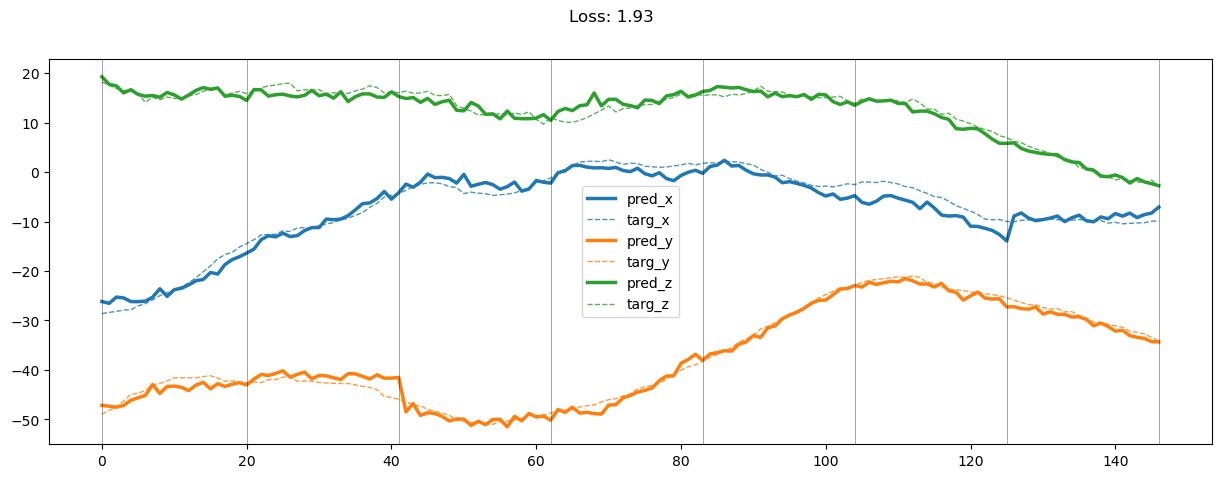

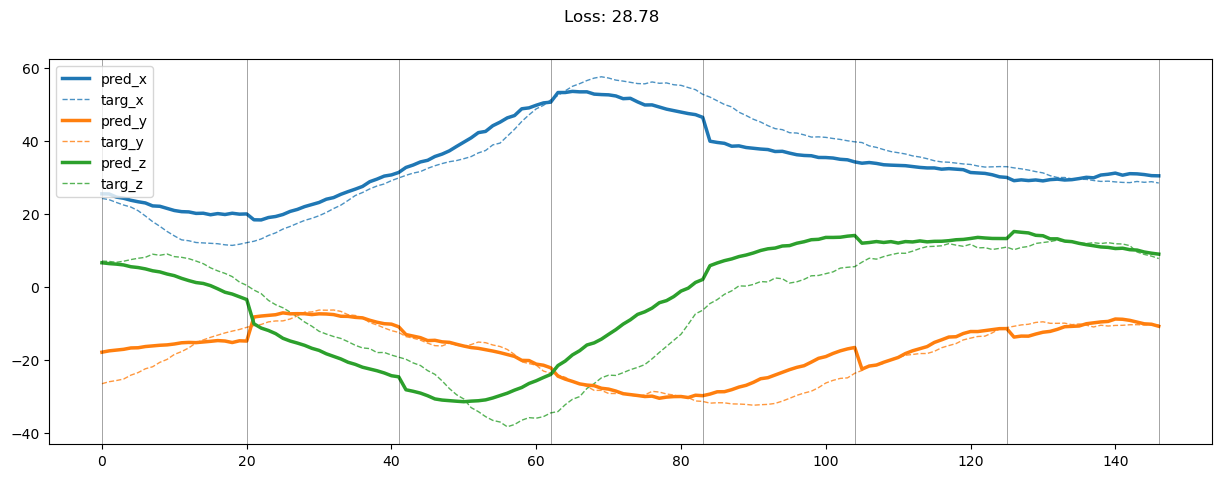

04599: train loss:  3.256, imu loss:  0.660, mag loss:  2.597
       valid loss:  78.225, imu loss:  0.510, mag loss:  77.715
04619: train loss:  3.270, imu loss:  0.671, mag loss:  2.600
       valid loss:  73.184, imu loss:  0.510, mag loss:  72.675
04639: train loss:  3.223, imu loss:  0.665, mag loss:  2.558
       valid loss:  75.900, imu loss:  0.510, mag loss:  75.390
04659: train loss:  3.224, imu loss:  0.660, mag loss:  2.564
       valid loss:  74.064, imu loss:  0.510, mag loss:  73.554
04679: train loss:  3.166, imu loss:  0.667, mag loss:  2.499
       valid loss:  77.102, imu loss:  0.510, mag loss:  76.592
04699: train loss:  3.161, imu loss:  0.664, mag loss:  2.496
       valid loss:  75.312, imu loss:  0.510, mag loss:  74.802
04719: train loss:  3.205, imu loss:  0.661, mag loss:  2.545
       valid loss:  76.269, imu loss:  0.510, mag loss:  75.759
04739: train loss:  3.136, imu loss:  0.665, mag loss:  2.471
       valid loss:  75.237, imu loss:  0.510, mag loss: 

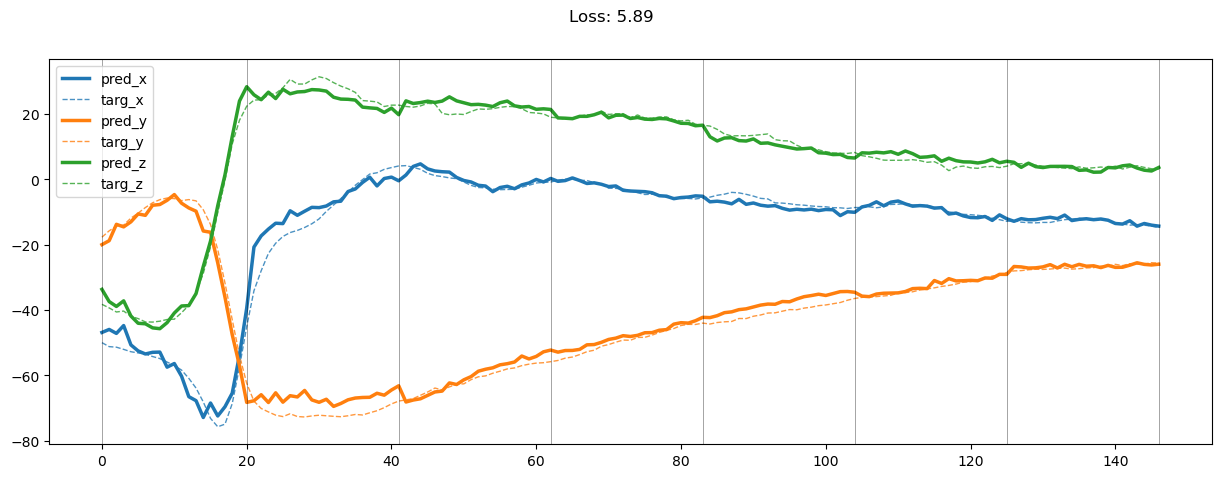

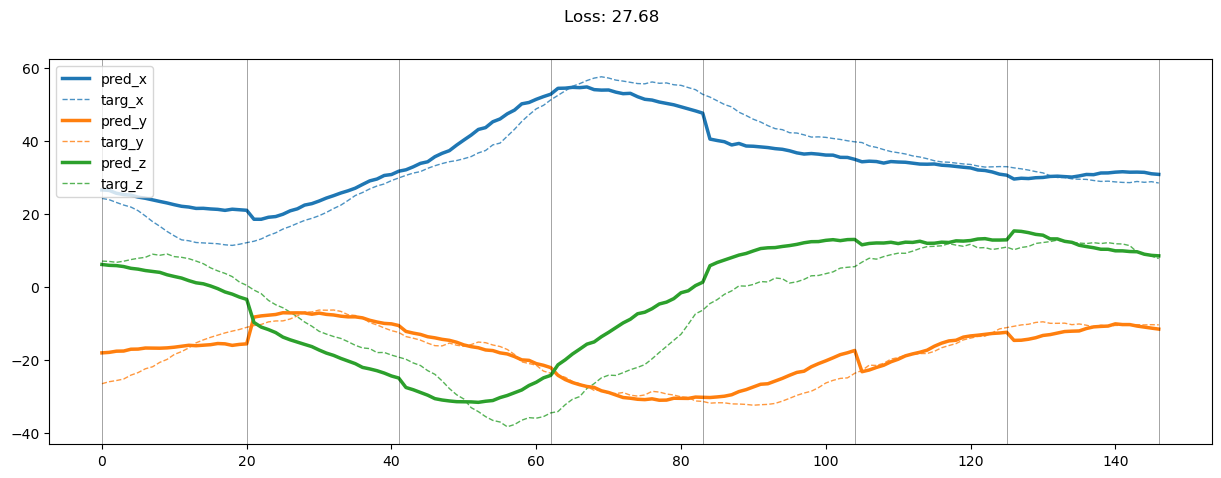

04799: train loss:  3.133, imu loss:  0.666, mag loss:  2.467
       valid loss:  74.201, imu loss:  0.510, mag loss:  73.691
04819: train loss:  3.086, imu loss:  0.669, mag loss:  2.416
       valid loss:  74.176, imu loss:  0.510, mag loss:  73.666
04839: train loss:  3.035, imu loss:  0.667, mag loss:  2.367
       valid loss:  76.810, imu loss:  0.510, mag loss:  76.300
04859: train loss:  3.022, imu loss:  0.660, mag loss:  2.362
       valid loss:  77.030, imu loss:  0.510, mag loss:  76.520
04879: train loss:  3.064, imu loss:  0.665, mag loss:  2.399
       valid loss:  76.221, imu loss:  0.510, mag loss:  75.711
04899: train loss:  3.038, imu loss:  0.665, mag loss:  2.373
       valid loss:  73.675, imu loss:  0.510, mag loss:  73.165
04919: train loss:  3.018, imu loss:  0.668, mag loss:  2.350
       valid loss:  77.982, imu loss:  0.510, mag loss:  77.472
04939: train loss:  2.982, imu loss:  0.660, mag loss:  2.322
       valid loss:  78.661, imu loss:  0.510, mag loss: 

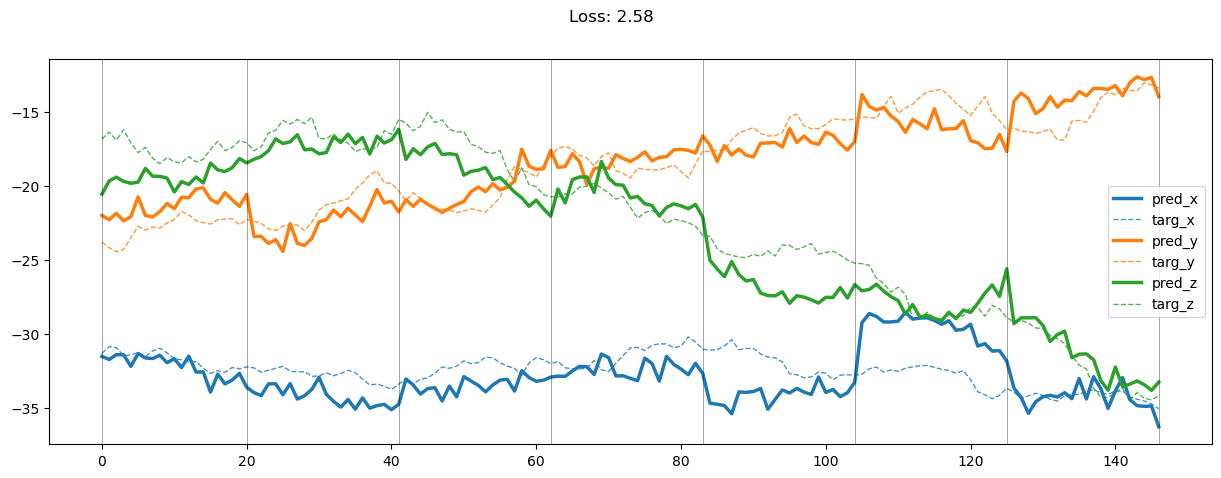

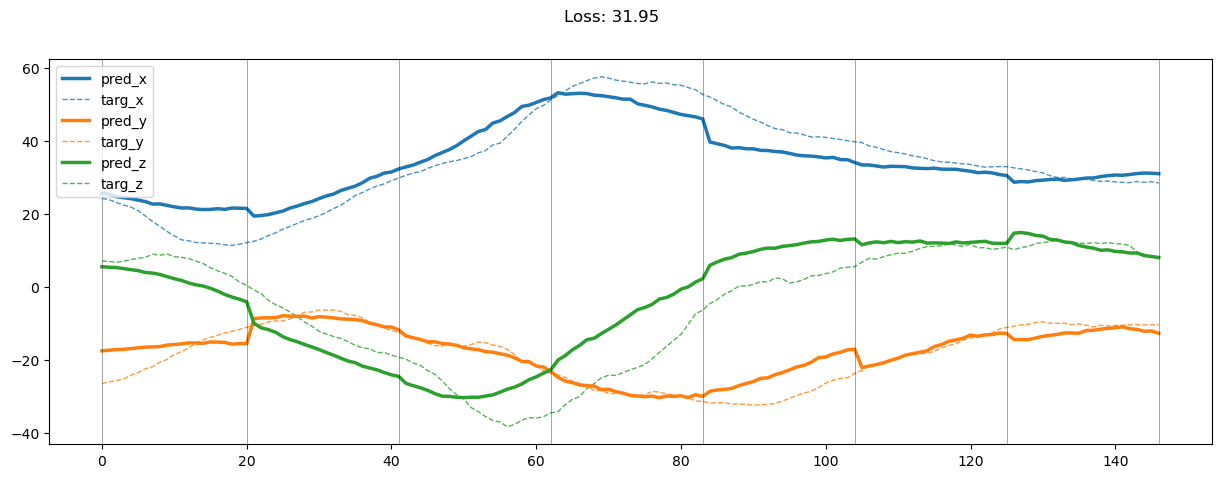

04999: train loss:  2.936, imu loss:  0.666, mag loss:  2.270
       valid loss:  75.747, imu loss:  0.510, mag loss:  75.237
05019: train loss:  2.965, imu loss:  0.666, mag loss:  2.299
       valid loss:  76.875, imu loss:  0.510, mag loss:  76.365
05039: train loss:  2.942, imu loss:  0.659, mag loss:  2.283
       valid loss:  76.994, imu loss:  0.510, mag loss:  76.484
05059: train loss:  2.957, imu loss:  0.667, mag loss:  2.290
       valid loss:  75.166, imu loss:  0.510, mag loss:  74.656
05079: train loss:  2.940, imu loss:  0.657, mag loss:  2.283
       valid loss:  77.036, imu loss:  0.510, mag loss:  76.526
05099: train loss:  2.858, imu loss:  0.660, mag loss:  2.198
       valid loss:  77.992, imu loss:  0.510, mag loss:  77.481
05119: train loss:  2.859, imu loss:  0.669, mag loss:  2.190
       valid loss:  76.580, imu loss:  0.510, mag loss:  76.070
05139: train loss:  2.883, imu loss:  0.676, mag loss:  2.207
       valid loss:  74.824, imu loss:  0.510, mag loss: 

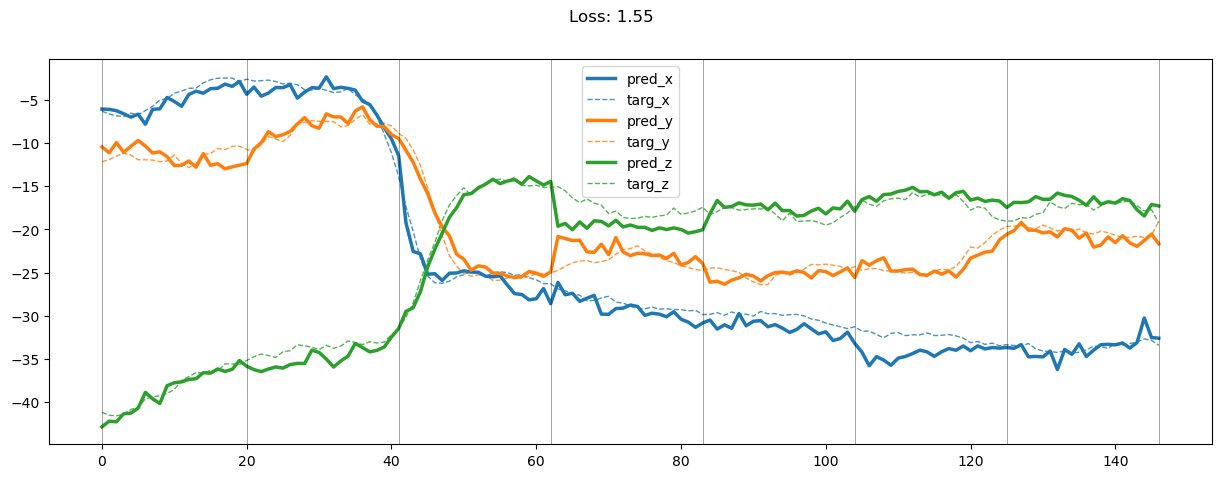

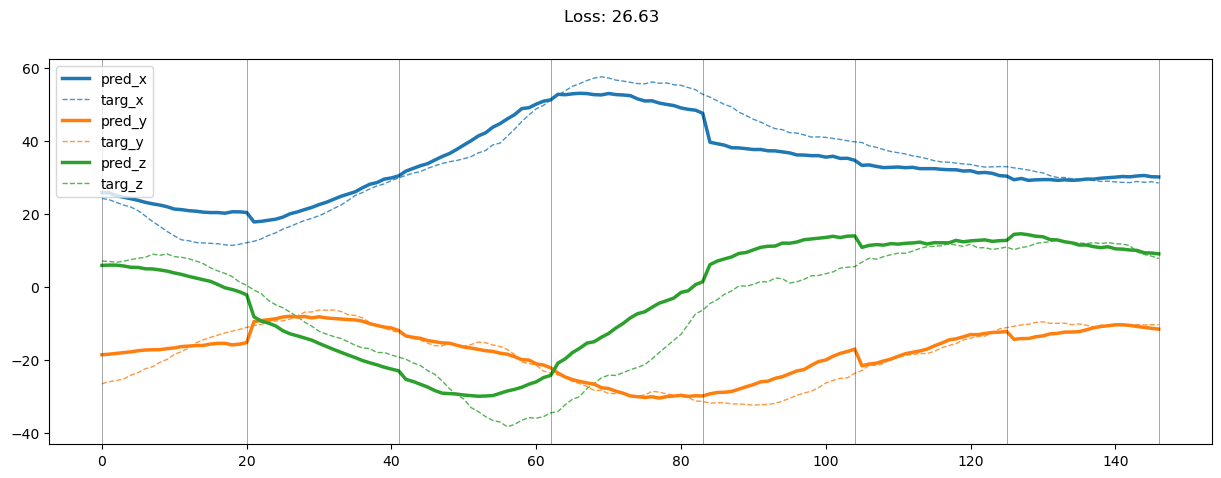

05199: train loss:  2.891, imu loss:  0.667, mag loss:  2.224
       valid loss:  77.622, imu loss:  0.510, mag loss:  77.112
05219: train loss:  2.784, imu loss:  0.658, mag loss:  2.126
       valid loss:  75.575, imu loss:  0.510, mag loss:  75.065


KeyboardInterrupt: 

In [29]:
draw = False

for epoch in range(EPOCH):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    if (epoch + 1) % 200 == 0:
        draw = True
    
    train_loss, train_imu_loss, train_mag_loss = train(train_loader, draw)
    valid_loss, valid_imu_loss, valid_mag_loss = evalute(valid_loader, draw)
    
    draw = False
    
    if (epoch + 1) % 20 == 0:
        ep = str(epoch).zfill(5)
        print(f'{ep:>5}: train loss: {train_loss: 2.3f}, imu loss: {train_imu_loss: 2.3f}, mag loss: {train_mag_loss: 2.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss: 2.3f}, imu loss: {valid_imu_loss: 2.3f}, mag loss: {valid_mag_loss: 2.3f}')

In [ ]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :, :6]
            source_mag = source_data[:, :, :, 6:9]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :, :6]
            target_mag = target_data[:, :, :, 6:9]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
            gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            
            results.extend(zip(predict_mag.detach().cpu().numpy(), target_data[:, :, :, 9:12].cpu().numpy()))
            
            break
    
    return np.array(results)

In [ ]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [ ]:
results = output_eval(model, train_loader)

print(results.shape)

for rs in results[::5]:
    plot_result(rs)

In [ ]:
results = output_eval(model, valid_loader)

print(results.shape)

for rs in results[::5]:
    plot_result(rs)